## Dataset

This section handles the loading and initial preparation of the MNIST dataset. MNIST contains 28x28 pixel grayscale images of handwritten digits (0-9).

**Key Operations:**

1.  **Data Loading (`load_mnist_images`, `load_mnist_labels`):**
    *   These functions read the MNIST dataset from its specific binary file format.
    *   Image data is reshaped to `(num_images, rows, cols)`.

2.  **One-Hot Encoding Labels:**
    *   For multi-class classification with a softmax output and categorical cross-entropy loss, integer labels (e.g., digit `5`) are converted into a one-hot vector format (e.g., `[0,0,0,0,0,1,0,0,0,0]` for 10 classes).
    *   This represents the true label as a probability distribution where the correct class has a probability of 1.

<figure style="text-align:center;">
    <img src="images/mnist_digits.png", style="border-radius:20px;", width="50%">
    <figcaption>Samples from the MNIST dataset</figcaption>
</figure>

In [4]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Leggi intestazione: magic number, numero immagini, righe, colonne
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Leggi tutti i pixel e convertili in array numpy
        images = np.frombuffer(f.read(), dtype=np.uint8)
        # Ridimensiona l'array in (num_images, rows, cols)
        images = images.reshape((num_images, rows, cols))
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

#-------------- Data Extraction ---------------------------
train_images = load_mnist_images('MNIST/train-images-idx3-ubyte')
train_labels = load_mnist_labels('MNIST/train-labels-idx1-ubyte')

test_images = load_mnist_images('MNIST/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('MNIST/t10k-labels.idx1-ubyte')

#--------------- Train data manipulation ------------------
print(train_images.shape)  # (60000, 28, 28)
print(train_labels.shape)  # (60000,)

one_hot_labels = np.zeros(train_labels.shape[0]*10).reshape((train_labels.shape[0]),10)
for i in range(len(train_labels)):
    one_hot_labels[i][train_labels[i]]=1
train_labels = one_hot_labels

print(train_labels.shape) # (60000,10)

#--------------- Test data manipulation -------------------
print(test_images.shape)  # (10000, 28, 28)
print(test_labels.shape)  # (10000,)

one_hot_labels = np.zeros(test_labels.shape[0]*10).reshape((test_labels.shape[0]),10)
for i in range(len(test_labels)):
    one_hot_labels[i][test_labels[i]]=1
test_labels = one_hot_labels

print(test_labels.shape) # (10000,10)

(60000, 28, 28)
(60000,)
(60000, 10)
(10000, 28, 28)
(10000,)
(10000, 10)


## PyTorch CNN Model Architecture

A Convolutional Neural Network (CNN) is defined using PyTorch's `nn.Module` to serve as a reference and source of pre-trained weights.

**Architecture (defined as `SimpleCNN` class):**

1.  **Conv1 + ReLU1:** `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0)`
    *   Input: `(B, 1, 28, 28)`
    *   Output dimension: $O = \lfloor \frac{(I - K + 2P)}{S} \rfloor + 1 = \lfloor \frac{(28 - 2 + 0)}{2} \rfloor + 1 = 14$
    *   Output: `(B, 32, 14, 14)`

2.  **Conv2 + ReLU2:** `nn.Conv2d(32, 64, 2, 2, 1)`
    *   Input: `(B, 32, 14, 14)`
    *   Padded input dimension: $14 + 2*1 = 16$
    *   Output dimension: $O = \lfloor \frac{(16 - 2 + 0)}{2} \rfloor + 1 = 8$
    *   Output: `(B, 64, 8, 8)`

3.  **Conv3 + ReLU3:** `nn.Conv2d(64, 128, 2, 2, 0)`
    *   Input: `(B, 64, 8, 8)`
    *   Output dimension: $O = \lfloor \frac{(8 - 2 + 0)}{2} \rfloor + 1 = 4$
    *   Output: `(B, 128, 4, 4)`

4.  **Flatten:** `nn.Flatten()`
    *   Input: `(B, 128, 4, 4)`
    *   Output: `(B, 128 * 4 * 4)` which is `(B, 2048)`

5.  **FC1 + ReLU4:** `nn.Linear(in_features=2048, out_features=250)`
    *   Input: `(B, 2048)`
    *   Operation: $Y = XW + b$
    *   Output: `(B, 250)`

6.  **FC2:** `nn.Linear(in_features=250, out_features=10)` (Output layer)
    *   Input: `(B, 250)`    
    *   Operation: $Y = XW + b$
    *   Output: `(B, 10)` (logits for 10 classes)

<figure style="text-align:center;">
    <img src="images/cnn.png", style="border-radius:20px;", height=300>
    <figcaption>CNN Architecture (B: Batch size)</figcaption>
</figure>

### Model and Dataset Declaration with Training

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
from tqdm import tqdm

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # --------- Convolutional Layers ------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.relu3 = nn.ReLU()
        # ---------- Flatten to become MLP's input -----------
        self.flatten = nn.Flatten()
        fc_input_size = 128 * 4 * 4
        # ---------- Multi Layer Perceptron ---------------
        # Only one hidden layer for classification
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=250)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=250, out_features=num_classes)

    def forward(self, x):
        # First convolution: from 1x1x28x28 to 1x32x14x14
        x = self.conv1(x)
        x = self.relu1(x)
        # Second Convolution: from 1x32x14x14 to 1x64x8x8
        x = self.conv2(x)
        x = self.relu2(x)
        # Third Convolution: from 1x64x8x8 to 1x128x4x4
        x = self.conv3(x)
        x = self.relu3(x)
        # Flatten
        x = self.flatten(x)
        # MLP
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x
    
# No bias version of the model
class SimpleCNN_no_bias(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN_no_bias, self).__init__()

        # --------- Convolutional Layers ------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0, bias=False)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1, bias=False)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0, bias=False)
        self.relu3 = nn.ReLU()
        # ---------- Flatten to become MLP's input -----------
        self.flatten = nn.Flatten()
        fc_input_size = 128 * 4 * 4
        # ---------- Multi Layer Perceptron ---------------
        # Only one hidden layer for classification
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=250)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=250, out_features=num_classes)

    def forward(self, x):
        # First convolution: from 1x1x28x28 to 1x32x14x14
        x = self.conv1(x)
        x = self.relu1(x)
        # Second Convolution: from 1x32x14x14 to 1x64x8x8
        x = self.conv2(x)
        x = self.relu2(x)
        # Third Convolution: from 1x64x8x8 to 1x128x4x4
        x = self.conv3(x)
        x = self.relu3(x)
        # Flatten
        x = self.flatten(x)
        # MLP
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

# # 2.------------------ CNN's Dataset declaration ----------------------

# class CNNDataset(Dataset):
#     def __init__(self, digits, labels, transform=None):
#         assert len(digits) == len(labels), "Number of digits and labels doesn't match"
#         self.digits = digits
#         self.labels = labels

#     def __len__(self):
#         return len(self.digits)

#     def __getitem__(self, idx):
#         digit = self.digits[idx]
#         label = self.labels[idx]
#         digit = digit.unsqueeze(0) # Needed operation to add the dimension of greyscale images (28,28) -> (1,28,28)
#         return digit, label

# tri = torch.from_numpy(train_images).float() / 255
# trl = torch.from_numpy(train_labels).float()
# tsi = torch.from_numpy(test_images).float() / 255
# tsl = torch.from_numpy(test_labels).float()

# train_dataset = CNNDataset(tri,trl)
# test_dataset = CNNDataset(tsi,tsl)

# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # 3.------ Training Setup ---------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(f"device: {device}")

# model = SimpleCNN(num_classes=10).to(device)

# # Loss definition
# criterion = nn.CrossEntropyLoss() 

# # Optimisation definition
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 5 

# # 4.------- cycle training ------

# print("\nStarting Training...")
# for epoch in range(num_epochs):

#     model.train() 

#     running_loss = 0.0
#     start_time = time.time()
#     #tqdm is module used to have a progress bar
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

#     for inputs, labels in progress_bar:

#         # move data on the device
#         inputs, labels = inputs.to(device), labels.to(device)

#         # make all gradients zero to avoid learning on gradients of previous steps
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs) 
#         # loss computation
#         loss = criterion(outputs, labels)

#         # Backward pass: compute the gradients
#         loss.backward()

#         # Weights update
#         optimizer.step()

#         # Update the loss
#         running_loss += loss.item() * inputs.size(0) # multiply for batch size to obtain the correct mean

#         # Update the progress bar
#         progress_bar.set_postfix(loss=f"{loss.item():.4f}")

#     # Epochs' mean loss computation
#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_time = time.time() - start_time

#     print(f"Epoch {epoch+1}/{num_epochs} - Tempo: {epoch_time:.2f}s - Training Loss: {epoch_loss:.4f}")

#     # --- Test evaluation (after every epoch) ---
#     model.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad(): # Disable gradient computation (we don't need gradients since we don't want to update the model in this phase)
#         i=0
#         for inputs, labels in test_loader:
#             if i >= 1:
#                 continue
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs.data, 1) # Obtain index with the maximum probability (it is our result)
#             _,labels = torch.max(labels,1) # same for the test labels
#             total += labels.size(0)
#             correct += (predicted==labels).sum().item()
#             i+=1

#     avg_test_loss = test_loss / len(test_loader.dataset)
#     accuracy = 100 * correct / total
#     print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy:.2f}%")


# print("\nTraining Complete.")
# #2m 9.4 secondi per avere un'epoca con cuda
# # save the model
# torch.save(model.state_dict(), 'simple_cnn_mnist.pth')

### Extracting Pre-trained Weights from PyTorch Model

This section loads weights from a pre-trained PyTorch model (`simple_cnn_mnist.pth`) and converts them into NumPy arrays. These NumPy weights will be used for our custom CNN implementations to ensure consistency for inference comparisons.

In [6]:
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('simple_cnn_mnist.pth', map_location=torch.device('cpu'),weights_only=True)) # Carica su CPU

model.eval() # A good practice is to set model in evaluation when you want to extract weights

# --- Parameters Extraction ⛏️ and Numpy Conversion ---

# Weights container
numpy_weights = {}

# Move model on cpu
model.to('cpu')

print("⛏️ Weights and Bias Extraction ⛏️\n")

# Layer Conv1
# PyTorch weight shape: (out_channels, in_channels, kernel_height, kernel_width)
# NumPy expected: (in_channels, out_channels, kernel_width, kernel_height) -> (1, 32, 3, 3)
pytorch_weights_of_kernels_in_layer_1 = model.conv1.weight.data.detach().numpy()
# Transpose: (out, in, kH, kW) -> (in, out, kW, kH)
numpy_weights['k1'] = pytorch_weights_of_kernels_in_layer_1

# PyTorch bias shape: (out_channels,)
numpy_weights['b_conv1'] = model.conv1.bias.data.detach().numpy() # Shape (32,)
print(f"k1: PyTorch Shape={pytorch_weights_of_kernels_in_layer_1.shape}, NumPy Shape={numpy_weights['k1'].shape}")
print(f"b_conv1: NumPy Shape={numpy_weights['b_conv1'].shape}")

# Layer Conv2
# PyTorch weight shape: (64, 32, 3, 3)
# NumPy expected: (32, 64, 3, 3)
pytorch_weights_of_kernels_in_layer_2 = model.conv2.weight.data.detach().numpy()
numpy_weights['k2'] = pytorch_weights_of_kernels_in_layer_2
numpy_weights['b_conv2'] = model.conv2.bias.data.detach().numpy() # Shape (64,)
print(f"k2: PyTorch Shape={pytorch_weights_of_kernels_in_layer_2.shape}, NumPy Shape={numpy_weights['k2'].shape}")
print(f"b_conv2: NumPy Shape={numpy_weights['b_conv2'].shape}")

# Layer Conv3
# PyTorch weight shape: (128, 64, 3, 3)
# NumPy expected: (64, 128, 3, 3)
pytorch_weights_of_kernels_in_layer_3 = model.conv3.weight.data.detach().numpy()
numpy_weights['k3'] = pytorch_weights_of_kernels_in_layer_3
numpy_weights['b_conv3'] = model.conv3.bias.data.detach().numpy() # Shape (128,)
print(f"k3: PyTorch Shape={pytorch_weights_of_kernels_in_layer_3.shape}, NumPy Shape={numpy_weights['k3'].shape}")
print(f"b_conv3: NumPy Shape={numpy_weights['b_conv3'].shape}")

# Layer FC1
# PyTorch weight shape: (out_features, in_features) -> (250, 2048)
# NumPy expected (per input @ W): (in_features, out_features) -> (2048, 250)
pytorch_fc1_layer_weights = model.fc1.weight.data.detach().numpy()
numpy_weights['w1'] = pytorch_fc1_layer_weights.T # Trasponi
# PyTorch bias shape: (out_features,) -> (250,)
# NumPy expected (per aggiunta diretta): (1, out_features) -> (1, 250)
pytorch_fc1_layer_biases = model.fc1.bias.data.detach().numpy()
numpy_weights['b1'] = pytorch_fc1_layer_biases.reshape(1, -1) # Rendi (1, 250)
print(f"w1: PyTorch Shape={pytorch_fc1_layer_weights.shape}, NumPy Shape={numpy_weights['w1'].shape}")
print(f"b1: PyTorch Shape={pytorch_fc1_layer_biases.shape}, NumPy Shape={numpy_weights['b1'].shape}")

# Layer FC2
# PyTorch weight shape: (num_classes, 250) -> (10, 250)
# NumPy expected: (250, num_classes) -> (250, 10)
pytorch_fc2_layer_weights = model.fc2.weight.data.detach().numpy()
numpy_weights['w2'] = pytorch_fc2_layer_weights.T # Trasponi
# PyTorch bias shape: (num_classes,) -> (10,)
# NumPy expected: (1, num_classes) -> (1, 10)
pytorch_fc2_layer_biases = model.fc2.bias.data.detach().numpy()
numpy_weights['b2'] = pytorch_fc2_layer_biases.reshape(1, -1) # Rendi (1, 10)
print(f"w2: PyTorch Shape={pytorch_fc2_layer_weights.shape}, NumPy Shape={numpy_weights['w2'].shape}")
print(f"b2: PyTorch Shape={pytorch_fc2_layer_biases.shape}, NumPy Shape={numpy_weights['b2'].shape}")

print("\nExtraction complete. Numpy weights are in the dictionary 'numpy_weights'.")

# Access Example:
np_k1 = numpy_weights['k1']
np_b_conv1 = numpy_weights['b_conv1']
np_k2 = numpy_weights['k2']
np_b_conv2 = numpy_weights['b_conv2']
np_k3 = numpy_weights['k3']
np_b_conv3 = numpy_weights['b_conv3']
np_w1 = numpy_weights['w1']
np_b1 = numpy_weights['b1']
np_w2 = numpy_weights['w2']
np_b2 = numpy_weights['b2']

⛏️ Weights and Bias Extraction ⛏️

k1: PyTorch Shape=(32, 1, 2, 2), NumPy Shape=(32, 1, 2, 2)
b_conv1: NumPy Shape=(32,)
k2: PyTorch Shape=(64, 32, 2, 2), NumPy Shape=(64, 32, 2, 2)
b_conv2: NumPy Shape=(64,)
k3: PyTorch Shape=(128, 64, 2, 2), NumPy Shape=(128, 64, 2, 2)
b_conv3: NumPy Shape=(128,)
w1: PyTorch Shape=(250, 2048), NumPy Shape=(2048, 250)
b1: PyTorch Shape=(250,), NumPy Shape=(1, 250)
w2: PyTorch Shape=(10, 250), NumPy Shape=(250, 10)
b2: PyTorch Shape=(10,), NumPy Shape=(1, 10)

Extraction complete. Numpy weights are in the dictionary 'numpy_weights'.


## CNN - NumPy implementation

### Padding

Zero-padding adds a border of zeros around an input image or feature map before convolution. For example:

$$
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
\quad \xrightarrow{\textcolor{lightgreen}{\textnormal{zero padding}}} \quad
\begin{bmatrix}
\textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 1 & 2 & 3 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 4 & 5 & 6 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 7 & 8 & 9 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0}
\end{bmatrix}
$$

It's important for:

1.  **Controlling Output Spatial Dimensions:** Padding can be used to maintain or control the reduction in height/width of feature maps. The output dimension (e.g., height $O_H$) is given by:
    $$ O_H = \left\lfloor \frac{I_H - K_H + 2P_H}{S_H} \right\rfloor + 1 $$
    where $I_H$ is input height, $K_H$ kernel height, $P_H$ padding on one side of height, and $S_H$ stride.
2.  **Improving Feature Extraction at Borders:** Allows the kernel to process edge pixels more effectively.

In [7]:
image_3_by_3 = np.arange(1,37).reshape(2,2,3,3)
padded_image_3_by_3 = np.pad(image_3_by_3,((0,0),(0,0),(1,1),(1,1)))
print(image_3_by_3)
print(padded_image_3_by_3)

[[[[ 1  2  3]
   [ 4  5  6]
   [ 7  8  9]]

  [[10 11 12]
   [13 14 15]
   [16 17 18]]]


 [[[19 20 21]
   [22 23 24]
   [25 26 27]]

  [[28 29 30]
   [31 32 33]
   [34 35 36]]]]
[[[[ 0  0  0  0  0]
   [ 0  1  2  3  0]
   [ 0  4  5  6  0]
   [ 0  7  8  9  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 10 11 12  0]
   [ 0 13 14 15  0]
   [ 0 16 17 18  0]
   [ 0  0  0  0  0]]]


 [[[ 0  0  0  0  0]
   [ 0 19 20 21  0]
   [ 0 22 23 24  0]
   [ 0 25 26 27  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 28 29 30  0]
   [ 0 31 32 33  0]
   [ 0 34 35 36  0]
   [ 0  0  0  0  0]]]]


### Matrix Dilatation

**Relevance in Backpropagation for $\frac{\partial L}{\partial X}$:**

This dilation operation is a critical step when computing the gradient of the loss with respect to the input of a convolutional layer ($\frac{\partial L}{\partial X}$), especially if the forward pass utilized a stride $S > 1$. Here is why:
* When a forward convolution uses a stride $S > 1$, it effectively downsamples the input, resulting in an output feature map $Z$ with smaller spatial dimensions.
* To calculate $\frac{\partial L}{\partial X}$, we need to use the gradient flowing back from the subsequent layer, $\frac{\partial L}{\partial Z}$ (where $Z$ is the output of the strided convolution). **Since the original input $X$ has larger spatial dimensions than $Z$, the gradient $\frac{\partial L}{\partial Z}$ must be "upsampled" or "spread out" before it can be convolved with the kernel weights to produce a gradient of the correct shape for $X$.**

**Dilation Step:** This upsampling is achieved by inserting $S-1$ rows and columns of zeros between the elements of $\frac{\partial L}{\partial Z}$.

After $\frac{\partial L}{\partial Z}$ is dilated to form $\left(\frac{\partial L}{\partial Z}\right)_{dilated}$, it is then typically padded (with $K-1$ zeros where $K$ is the kernel dimension, adjusted for any original padding) and subsequently convolved with the 180-degree rotated (or flipped) kernel ($W_{rot180}$). This entire sequence of operations (padding the dilated output gradient and convolving it with the flipped kernel) is what yields $\frac{\partial L}{\partial X}$ and is often referred to as a "full convolution" in this context (see "A guide to convolution arithmetic for deep learning" by Dumoulin and Visin, or the provided articles by Mayank Kaushik).

The image below illustrates the concept of dilating an output gradient tensor. This dilation is a preparatory step before the gradient is used in further convolution operations during backpropagation for layers that had striding in their forward pass.

<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*luRORFyTmj9mJ7rVhzlbZA.png" height=250, style="border-radius:20px;">
</figure>

Illustrative example of dilating an output gradient tensor (like $\frac{\partial L}{\partial Z}$) by inserting $S-1$ (stride minus one) zeros. In this case, $S=2$, so one row and one column of zeros is inserted between elements.
<div style="text-align:center;"><p><i><a href="https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710">(Source: Backpropagation for Convolution with Strides, Mayank Kaushik)</a></i><p></div>

Dilatation in case of original stride = 3
Original Image Shape: (1, 1, 2, 2)
Dilated Image Shape: (1, 1, 4, 4)


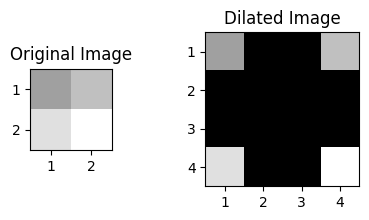

In [8]:
def dilate(tensor, stride):
    if stride == 1:
        return tensor

    batch_size, num_channels, height, width = tensor.shape
    
    dilated_height = height + (height - 1) * (stride - 1)
    dilated_width = width + (width - 1) * (stride - 1)
    
    dilated_tensor = np.zeros((batch_size, num_channels, dilated_height, dilated_width)).astype(tensor.dtype)
    dilated_tensor[:, :, ::stride, ::stride] = tensor
    return dilated_tensor

# Example usage of dilate function
example_image = np.arange(5, 9).reshape(1, 1, 2, 2)
dilated_image = dilate(example_image, 3)
print("Dilatation in case of original stride = 3")
print("Original Image Shape:", example_image.shape)
print("Dilated Image Shape:", dilated_image.shape)

fig, axs = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'width_ratios': [0.3, 1]})
plt.subplot(1, 2, 1)
plt.imshow(example_image[0, 0], cmap='gray', vmin=0, vmax=8)
plt.xticks([0, 1], [1, 2])
plt.yticks([0, 1], [1, 2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(dilated_image[0, 0], cmap='gray', vmin=0, vmax=8)
plt.xticks([0, 1, 2, 3], [1, 2, 3, 4])
plt.yticks([0, 1, 2, 3], [1, 2, 3, 4])
plt.title('Dilated Image')
plt.show()

### Benchmark network (debug and testing purpose)

In [9]:
import torch
import torch.nn.functional as F
from torch import nn

class TesterCNN(nn.Module):
    def __init__(self, kernels: torch.Tensor, biases: torch.Tensor = None, stride=1, padding=0):
        super().__init__()
        out_ch, in_ch, k_h, k_w = kernels.shape
        self.stride = stride
        self.padding = padding
        
        self.conv = nn.Conv2d(in_channels=in_ch,
                              out_channels=out_ch,
                              kernel_size=(k_h, k_w),
                              stride=stride,
                              padding=padding,
                              bias=(biases is not None))
        with torch.no_grad():
            self.conv.weight.copy_(kernels)
            if biases is not None:
                self.conv.bias.copy_(biases)

        self.conv.weight.requires_grad_(False)
        if biases is not None:
            self.conv.bias.requires_grad_(False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.conv(x))

## Nested-Loops Approach

### Nested-Loops Approach: Convolutional Layer - Forward

`nested_loop_convolution` implements a 2D convolution followed by ReLU activation using explicit nested loops. This is computationally highly inefficient.

**Inputs:**
    *   `batch_of_images`: size `(N, C_in, H_in, W_in)`.
    *   `kernels`: size `(C_out, C_in, K_H, K_W)`.
    *   `biases`: Per-filter biases `(C_out,)`.

**Steps:**
1.  **Padding & Output Size:** Input `batch_of_images` is padded to better extract information from tha borders of the images. Output dimensions $(O_H, O_W)$ are calculated using the formula in the Padding section.
2.  **Convolution:** The convolution is computed explicitly, iterating over each element of the patches from the input tensor and multiplying them by the "sliding" kernels. For each output element $(n, f, y_{out}, x_{out})$:
    $$ \text{Output}(n, f, y_{out}, x_{out}) = \left( \sum_{c=0}^{C_{in}-1} \sum_{k_y=0}^{K_H-1} \sum_{k_x=0}^{K_W-1} \text{Img}_{pad}(n, c, y_{out}S + k_y, x_{out}S + k_x) \cdot \text{Ker}(f, c, k_y, k_x) \right) + \text{Bias}(f) $$
3.  **ReLU Activation:** If `applyReLU=True`: $\text{ActivatedOutput} = \max(0, \text{Output})$. A binary `mask` (1 where Output > 0, else 0) is also returned for backpropagation.

<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/refs/heads/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif" height="250", style="border-radius:20px;"/>
    <figcaption>Convolution of a 7x7 image (blue) with a 3x3 kernel (gray), resulting in a 5x5 output (green). <br><i><a href"https://arxiv.org/pdf/1603.07285">(Source: A guide to convolution arithmetic for deep learning - Dumoulin & Visin)</a></i>

In [10]:
def nested_loop_convolution(batch_of_images, kernels, biases=np.array(0), padding=0, stride=1, applyReLU=True):
    if applyReLU: # Forward case
        output_channels, input_channels, kernel_width, kernel_height = kernels.shape
        kernel_channels = output_channels
    else: # Backward case
        input_channels, output_channels, kernel_width, kernel_height = kernels.shape
        kernel_channels = input_channels

    # biases has shape (output_channels, 1, 1). It's a scalar value for each channel broadcasted to the kernel's width and height
    # The number of channels taken in input by the kernel 'input_channels' must be the same as the number of channels of the image 'channels'

    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))
    batch_size, channels, image_height, image_width  = batch_of_images.shape
    output_image_height = int(((image_height - kernel_height) / stride) + 1) # new image height # Padding is already added
    output_image_width = int(((image_width - kernel_width) / stride) + 1) # new image width
    output = np.zeros((batch_size, output_channels, output_image_height, output_image_width)).astype(np.float32) # new image

    if input_channels != channels:
        raise ValueError(f"number of channels taken in input by the kernel ({input_channels}) must be the same as the number of channels of the image ({channels})")

    for single_image in range(batch_size):
        for single_kernel_channel in range(kernel_channels):
            for output_row_idx in range(output_image_height): # which cycles row by row of the new image
                for output_col_idx in range(output_image_width): # which cycles column by column of the new image
                    output_cell_accumulator = 0.0  # sum for the current output cell (accumulates the convolution result)
                    # Convolution cycles
                    for channel in range(input_channels): # channels == input_channels
                        for kernel_row_idx in range(kernel_height):
                            # Position of the kernel over the input image: row
                            input_row_idx = (output_row_idx * stride) + kernel_row_idx
                            for kernel_col_idx in range(kernel_width):
                                # Position of the kernel over the input image: column
                                input_col_idx = (output_col_idx * stride) + kernel_col_idx

                                # Check if the position is inside the image
                                if 0 <= input_row_idx < image_height and 0 <= input_col_idx < image_width:
                                    input_element = batch_of_images[single_image, channel, input_row_idx, input_col_idx]
                                    kernel_element = kernels[single_kernel_channel, channel, kernel_row_idx, kernel_col_idx]
                                    # Compute the convolution sum (to be done for each element of the sliding kernel over the image)
                                    output_cell_accumulator += (input_element * kernel_element).astype(np.float32)

                    # Assign the result to the output image
                    output[single_image, single_kernel_channel, output_row_idx, output_col_idx] = output_cell_accumulator

    if biases.all() != 0:
        biases = biases.reshape(biases.shape[0],1,1)

        if biases.shape[0] != output_channels:
            raise ValueError(f"biases dimension ({biases.shape[0]}) doesn't match kernel's number of channels ({output_channels})")
        
        output = output + biases

    output = output.astype(np.float32)

    if applyReLU:
        output = np.maximum(0, output)
        mask = output.copy()
        mask[mask > 0] = 1

        return output, mask
    else:
        return output

#-------------------------------------------- Examples --------------------------------------------------------
example_image = np.arange(1,3*3+1).reshape(1,1,3,3).astype(np.float32)
print("-------example_image--------")
print(example_image)

example_kernel = np.arange(1,8+1).reshape(2,1,2,2)
print("-------example_kernel-------")
print(example_kernel)

example_biases = np.array([1,2]).reshape(2,1,1)
outpout, mask = nested_loop_convolution(example_image, example_kernel, biases=example_biases, padding=1, stride=2)
print("-------Nested-Loop approach-------")
print(outpout)
# print("------mask-------")
# print(mask)

example_kernel = torch.from_numpy(example_kernel).float()
example_biases = torch.from_numpy(np.array([1,2])).float()
testerCNNmodel = TesterCNN(kernels=example_kernel,biases=example_biases, stride=2, padding=1)

x = torch.from_numpy(example_image)
y = testerCNNmodel(x)
print("-------PyTorch model-------")
print(y)

-------example_image--------
[[[[1. 2. 3.]
   [4. 5. 6.]
   [7. 8. 9.]]]]
-------example_kernel-------
[[[[1 2]
   [3 4]]]


 [[[5 6]
   [7 8]]]]
-------Nested-Loop approach-------
[[[[  5.  19.]
   [ 37.  78.]]

  [[ 10.  40.]
   [ 82. 191.]]]]
-------PyTorch model-------
tensor([[[[  5.,  19.],
          [ 37.,  78.]],

         [[ 10.,  40.],
          [ 82., 191.]]]])


### Nested-Loops Approach: Convolutional Layer - Backward

We now need to implement the backward pass of a convolutional layer, calculating the gradients of the loss function with respect to the layer's weights (or kernels) ($W^{(i)}$), biases ($b^{(i)}$), and the layer's input (images) ($X^{(i)}$).

**Notation:**
*   $L$: The Loss function.
*   $X^{(i)}$: The input to convolutional layer $i$.
*   $W^{(i)}$: The weights (kernels) of layer $i$.
*   $b^{(i)}$: The biases of layer $i$.
*   $Z^{(i)}$: The pre-activation output of layer $i$ ($Z^{(i)} = \text{conv}(X^{(i)}, W^{(i)}) + b^{(i)}$).
*   $A^{(i)}$: The activated output of layer $i$ (e.g., $A^{(i)} = \text{ReLU}(Z^{(i)})$).
*   $\frac{\partial L}{\partial A^{(i)}}$: The gradient of the loss with respect to the activated output $A^{(i)}$ of the current layer (propagated from the next layer).
*   $\frac{\partial L}{\partial Z^{(i)}}$: The gradient of the loss with respect to the pre-activation output $Z^{(i)}$ of the current layer. This is often denoted as $\delta^{(i)}$ in your original text after passing through the ReLU derivative.
*   $\text{mask}^{(i)}$: The binary mask derived from the ReLU activation in the forward pass (1 if $Z^{(i)} > 0$, else 0).

**Steps:**

1.  **Gradient through ReLU Activation (Backward ReLU):**
    The derivative of ReLU is 1 for positive inputs and 0 otherwise. This is efficiently implemented by element-wise multiplying the incoming gradient $\frac{\partial L}{\partial A^{(i)}}$ with the `mask` computed during the forward pass.
    $$
    \frac{\partial L}{\partial Z^{(i)}} = \frac{\partial L}{\partial A^{(i)}} \odot \text{mask}^{(i)}
    $$
    where $\odot$ denotes the Hadamard (element-wise) product. Henceforth, for brevity, we will denote $\frac{\partial L}{\partial Z^{(i)}}$ as $\delta_Z^{(i)}$.

2.  **Gradient with respect to Weights ($W^{(i)}$):**
    To calculate $\frac{\partial L}{\partial W^{(i)}}$, we need to correlate the layer's input $X^{(i)}$ with the pre-activation output gradient $\delta_Z^{(i)}$. Each weight $W_{f,c,k_y,k_x}$ contributes to multiple elements of the output $Z^{(i)}$. Its gradient is the sum of all these contributions. Mathematically, this is equivalent to a convolution between the input $X^{(i)}$ (appropriately padded as in the forward pass) and the gradient $\delta_Z^{(i)}$ (which is treated as the "kernel" for this convolution).
    $$
    \frac{\partial L}{\partial W^{(i)}} = \text{Convolution}(X^{(i)}_{padded}, \delta_Z^{(i)})
    $$
    This convolution must always have a stride = 1.
* **Dilation of $\delta_Z^{(i)}$ (if forward stride > 1):** If the forward pass used a stride $S > 1$, $\delta_Z^{(i)}$ must be dilated by inserting $S-1$ zeros between its elements *before* this convolution for $\frac{\partial L}{\partial W^{(i)}}$. **This technique allows the use of a standard convolution**, where the "kernel" ($\delta_Z^{(i)}$) slides over the "image" ($X^{(i)}$), and makes the output's size equal to the one of the original kernel.
    
    (If $X^{(i)}$ is $(N, C_{in}, H_{in}, W_{in})$ and $\delta_Z^{(i)}$ is $(N, C_{out}, H_{out}, W_{out})$, the result $\frac{\partial L}{\partial W^{(i)}}$ will have shape $(C_{out}, C_{in}, K_H, K_W)$, as the original kernel.)

3.  **Gradient with respect to Input ($X^{(i)}$):**
    To propagate the gradient to the previous layer, we also need to calculate $\frac{\partial L}{\partial X^{(i)}}$. This operation is known as a "Full Convolution". It involves convolving the gradient $\delta_Z^{(i)}$ with the kernels $W^{(i)}$ rotated by 180 degrees (or flipped both horizontally and vertically) ($W^{(i)}_{rot180}$).
    $$
    \frac{\partial L}{\partial X^{(i)}} = \text{FullConvolution}(\delta_Z^{(i)}, W^{(i)}_{rot180})
    $$
    ***Note:*** *The name "Full Convolution" refers to the fact that the first term of the operation is padded as much as possible (a larger padding would make some patches contain only zeros, so it would not make sense).*
    
    Full Convolution is implemented as follows:
    *   **Dilation of $\delta_Z^{(i)}$:** As for the gradient w.r.t. the weights, if the stride $S$ of the forward pass was greater than 1, $\delta_Z^{(i)}$ is "dilated". Let's call this $\delta_{Z,dilated}^{(i)}$. If $S=1$, $\delta_{Z,dilated}^{(i)} = \delta_Z^{(i)}$.
    *   **Padding of $\delta_{Z,dilated}^{(i)}$:** The dilated gradient is padded. If $P_{fwd}$ was the forward pass padding and $K$ the kernel dimension, the padding here is $K-1-P_{fwd}$ on each side.
    *   **Convolution:** The padded $\delta_{Z,dilated}^{(i)}$ is convolved with $W^{(i)}_{rot180}$. The stride of this convolution is always 1.
    The result $\frac{\partial L}{\partial X^{(i)}}$ will have the same spatial dimensions as the original input $X^{(i)}$.

4.  **Gradient with respect to Biases ($b^{(i)}$):**
    Since the bias $b_c^{(i)}$ (corresponding to filter $c$) is added to all elements of channel $c$ of the pre-activation output $Z^{(i)}$, its gradient is simply the sum of all elements of $\delta_Z^{(i)}$ (the gradient *before* dilation) over that channel, across the spatial dimensions (height and width) and across all examples in the batch.
    $$
    \frac{\partial L}{\partial b^{(i)}_c} = \sum_{n} \sum_{h,w} (\delta_Z^{(i)})_{n,c,h,w}
    $$
---
<div style="text-align:center;">
<b>Visual example of forward and backward pass, with padding = 1 and striding = 2:</b>
<div style="display:flex; flex-direction:row; justify-content:space-between; align-items:flex-start; margin-top:15px;">
<figure style="text-align:center; width:50%; flex-grow:1; margin-top:0px;">
    <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/padding_strides.gif", style="border-radius:20px; height:200px;"/>
    <figcaption> The input image (blue) is 5x5, and the kernel (gray) is 3x3. The input has padding = 1 a stride = 2 is used. As we can see, the output is 3x3.</figcaption>
</figure>
<figure style="text-align:center; width:50%; flex-grow:1; margin-top:0px;">
    <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_transposed.gif", style="border-radius:20px; height:200px;"/>
    <figcaption>Corresponding backward phase: the output gradient of the previous convolution is the 3x3 blue input. It is padded and dilated by stride-1=2-1=1 and convolved with the rotated kernel (gray) to produce the input gradient (5x5 green output).</figcaption>
</figure>
</div>
<figcaption style="text-align:center;"><i><a href"https://arxiv.org/pdf/1603.07285">(Source: A guide to convolution arithmetic for deep learning - Dumoulin & Visin)</a></i>
</fgcaption>
</div>

In [11]:
def nested_loop_gradient(batch_of_images, d_output_activated, kernels, mask, padding=0, stride=1):
    """
    Performs the backward pass of the convolution layer using nested loops.
    It takes the original input image batch, the gradient of the loss w.r.t. the activated output of this layer,
    the kernels, forward pass padding, and forward pass stride.
    The mask is needed to perform the ReLU backward operation.
    Returns:
        gradient_wrt_input (dL/dX_current_layer)
        gradient_wrt_kernel (dL/dW_current_layer)
        gradient_wrt_bias (dL/db_current_layer)
    """
    batch_size, num_input_channels_img, img_height_orig, img_width_orig = batch_of_images.shape
    num_output_channels_k, num_input_channels_k, kernel_height, kernel_width = kernels.shape

    if num_input_channels_img != num_input_channels_k:
        raise ValueError("Kernel input channels and image input channels must match.")

    # Backward ReLU: dL/dZ = dL/dA * mask
    # d_output_activated is dL/dA (gradient from next layer w.r.t. this layer's activated output)
    dLdZ = np.multiply(d_output_activated, mask) # Gradient w.r.t. pre-activation output

    # --- Gradient w.r.t. Biases (dL/db) ---
    # Sum dLdZ over batch, height, and width dimensions for each output channel
    gradient_wrt_bias = np.sum(dLdZ, axis=(0, 2, 3)) # Shape: (num_output_channels_k,)

    # --- Gradient w.r.t. Input (dL/dX) ---
    # This is a "full convolution" of dLdZ_dilated with kernels_rotated_180
    dLdZ_dilated = dilate(dLdZ, stride)
    
    # Padding for the "full convolution" to get dL/dX
    # Output size O = (I - K + 2P_conv) / S_conv + 1. We want O = img_height_orig
    # Here, S_conv = 1. K_eff = kernel_height. I_eff = dLdZ_dilated_height
    # So, img_height_orig = dLdZ_dilated_height - kernel_height + 2P_conv + 1
    # P_conv_total = img_height_orig - dLdZ_dilated_height + kernel_height - 1
    # The provided formula in texts for dL/dX padding is K_fwd - 1 - P_fwd (on each side)
    pad_h_dx = kernel_height - 1 - padding
    pad_w_dx = kernel_width - 1 - padding

    dLdZ_dilated_padded = np.pad(dLdZ_dilated,
                                 ((0,0), (0,0), (pad_h_dx, pad_h_dx), (pad_w_dx, pad_w_dx)),
                                 mode='constant', constant_values=0)

    kernels_rot180 = np.rot90(kernels, 2, axes=(-2, -1)) # Rotate each kernel by 180 deg

    gradient_wrt_input = np.zeros_like(batch_of_images, dtype=np.float32)
    
    # Convolution: dLdZ_dilated_padded with kernels_rot180 (stride 1)
    # kernels_rot180 shape: (C_out_k, C_in_k, KH, KW)
    # For dL/dX, the "output channels" of this conv are C_in_k (original input channels)
    # and "input channels" are C_out_k (output channels of dLdZ)
    
    # Iterate over batch
    for n in range(batch_size):
        # Iterate over output channels of dL/dX (which are input channels of original image)
        for c_in_orig in range(num_input_channels_img):
            # Iterate over spatial dimensions of dL/dX (original image dimensions)
            for r_out_dx in range(img_height_orig):
                for c_out_dx in range(img_width_orig):
                    current_sum_dx = 0.0
                    # Iterate over "input channels" for this conv (which are output channels of dLdZ)
                    for c_out_fwd in range(num_output_channels_k):
                        # Iterate over kernel spatial dimensions
                        for kr in range(kernel_height):
                            for kc in range(kernel_width):
                                r_in_conv = r_out_dx + kr # Stride is 1 for this conv
                                c_in_conv = c_out_dx + kc
                                
                                if 0 <= r_in_conv < dLdZ_dilated_padded.shape[2] and \
                                   0 <= c_in_conv < dLdZ_dilated_padded.shape[3]:
                                    val_dLdZ = dLdZ_dilated_padded[n, c_out_fwd, r_in_conv, c_in_conv]
                                    # kernel_rot180[c_out_k_idx_as_input_channel, c_in_k_idx_as_output_channel, kr, kc]
                                    # For dL/dX: kernel_rot180 "output channels" map to C_in_orig
                                    # "input channels" map to C_out_fwd (dLdZ channels)
                                    # kernels_rot180 is (orig_C_out, orig_C_in, KH, KW)
                                    # We need kernel_rot180[c_out_fwd, c_in_orig, kr, kc] if thinking about it as transposed conv
                                    # Or, if thinking of it as a standard conv:
                                    # output_channel_of_conv = c_in_orig
                                    # input_channel_of_conv = c_out_fwd
                                    # So kernel is kernel_flipped[c_in_orig, c_out_fwd, kr, kc]
                                    # Let's use the (C_out_orig, C_in_orig, KH, KW) indexing for kernels_rot180,
                                    # and map it to the conv:
                                    # kernels_rot180_for_conv_output_c_in_orig_input_c_out_fwd[kr,kc]
                                    # = kernels_rot180[c_out_fwd, c_in_orig, kr, kc] (after transposing kernel channels)
                                    # This is a bit confusing with nested loops. Let's use the common perspective:
                                    # dL/dX[n, c_in, y, x] = sum_{c_out, kh, kw} dL/dZ_dilated_padded[n, c_out, y+kh, x+kw] * W_rot[c_out, c_in, kh, kw]
                                    # Or, W_rot has shape (C_in_new, C_out_new, KH, KW)
                                    # where C_in_new = C_out_orig, C_out_new = C_in_orig
                                    # So kernel is kernels_rot180_conv[c_in_orig, c_out_fwd, kr, kc]
                                    # which means we need to permute axes of kernels_rot180 (C_out_k, C_in_k, KH, KW)
                                    # to (C_in_k, C_out_k, KH, KW) to treat it as a standard conv kernel
                                    # kernels_rot180_permuted = kernels_rot180.transpose(1,0,2,3)
                                    # val_kernel = kernels_rot180_permuted[c_in_orig, c_out_fwd, kr, kc]

                                    # Simpler: use original kernel indexing and match terms
                                    # W_rot180[num_output_channels_k, num_input_channels_k, KH, KW]
                                    # dL/dX_c_in[y,x] = sum_{c_out} (dL/dZ_c_out_dilated_padded * W_rot[c_out, c_in, :, :])
                                    val_kernel = kernels_rot180[c_out_fwd, c_in_orig, kr, kc]
                                    current_sum_dx += val_dLdZ * val_kernel
                    gradient_wrt_input[n, c_in_orig, r_out_dx, c_out_dx] = current_sum_dx

    # --- Gradient w.r.t. Kernel (dL/dW) ---
    # This is a convolution of batch_of_images_padded_fwd with dLdZ (potentially dilated for dW, or use strided access)
    # Output should have shape of kernels: (num_output_channels_k, num_input_channels_k, kernel_height, kernel_width)
    # dL/dW[c_out, c_in, kr, kc] = sum_{n, r_out, c_out} dL/dZ[n, c_out, r_out, c_out] * X_padded_fwd[n, c_in, r_out*S + kr, c_out*S + kc]
    
    batch_of_images_padded_fwd = np.pad(batch_of_images,
                                     ((0,0), (0,0), (padding,padding), (padding,padding)),
                                     mode='constant', constant_values=0)

    gradient_wrt_kernel = np.zeros_like(kernels, dtype=np.float32)
    
    # Iterate over output channels of kernel (filters)
    for f_out in range(num_output_channels_k):
        # Iterate over input channels of kernel
        for c_in_k_idx in range(num_input_channels_k):
            # Iterate over kernel spatial dimensions (this defines the dW element we are computing)
            for kr_idx in range(kernel_height):
                for kc_idx in range(kernel_width):
                    current_sum_dw = 0.0
                    # Sum over batch
                    for n in range(batch_size):
                        # Sum over spatial dimensions of dLdZ
                        for r_dLdZ in range(dLdZ.shape[2]): # dLdZ height
                            for c_dLdZ in range(dLdZ.shape[3]): # dLdZ width
                                # Corresponding input patch element from batch_of_images_padded_fwd
                                r_in_img = r_dLdZ * stride + kr_idx
                                c_in_img = c_dLdZ * stride + kc_idx
                                
                                if 0 <= r_in_img < batch_of_images_padded_fwd.shape[2] and \
                                   0 <= c_in_img < batch_of_images_padded_fwd.shape[3]:
                                    val_img = batch_of_images_padded_fwd[n, c_in_k_idx, r_in_img, c_in_img]
                                    val_dLdZ_elem = dLdZ[n, f_out, r_dLdZ, c_dLdZ]
                                    current_sum_dw += val_dLdZ_elem * val_img
                    gradient_wrt_kernel[f_out, c_in_k_idx, kr_idx, kc_idx] = current_sum_dw
    
    return gradient_wrt_input, gradient_wrt_kernel, gradient_wrt_bias

## Im2Col Approach

### Im2Col approach: Convolutional Layer - Forward

<html>
<head>
    <style>
    td      {vertical-align: middle;}
    body    {text-align: center}
    table, th, tr, td {border-collapse: collapse}
    </style>
</head>
<body>
<p><code>im2col_convolution</code> implements 2D convolution more efficiently using an Im2Col approach using<code>sliding_window_view</code> and optimized matrix multiplication.</p>

<p><strong>Im2Col Core Idea:</strong></p>

<table style="width: 100%;">
    <tbody>
        <tr>
            <td style="width: 65%; padding: 25px 25px 0 25px;">
                <ol><li><strong>Input Patch Extraction:</strong></li><br>
                <ul>
                    <li>
                        <code>window_m = ... .reshape((-1,(kw*kh*nc)))</code>: Flattens each extracted patch into a row vector of size <code>kw*kh*nc</code>. <code>window_m</code> (our $X_{col}$) thus has shape <code>(N_patches, patch_size)</code>.
                    </li>
                    <li>
                        <code>kernel = kernel.reshape((-1,(kw*kh*nc))).transpose(1,0)</code>: Flattens each filter <code>(kc, ac, kw, kh)</code> -> <code>(kc, ac*kw*kh)</code>. This is $W_{col}$, shape <code>(patch_size, C_out)</code>.
                    </li>
                </ul>
                </ol>
                <p>
                    Following the example in the animation below, we have a 4x4 RGB image (so <strong>3x4x4</strong>) that has to be convoluted by a <strong>2x2</strong> kernel (represented as the red outlines sliding over the image). The kernel will slide <strong>9</strong> times over the image and, for each slide, the number of multiplications and values to be summed is 4 (elements of the kernel) times 3 (channels of both the image and the kernel) that equals <strong>12</strong>. Hence, as we can see in the animation below, the flattened patches are vectors of <strong>12</strong> elements, and in total they are <strong>9</strong>, as the slides performed by the kernel.
                </p>
            </td>
            <td>
                <figure style="text-align:center;">
                    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/1.gif" height="250" style="border-radius:20px; max-width: 100%;"/>
                    <figcaption>Each patch is extracted and flattened into a vector</figcaption>
                </figure>
            </td>
        </tr>
        <tr>
            <td style="width: 65%; padding: 25px;">
                <ol start="2"><li><strong>Kernel Reshaping:</strong></li></ol>
                <p>
                    To perform the convolution as a vector-matrix multiplication (or matrix-matrix multiplication) we then have to flatten the kernel(s) into row vectors.
                </p>
            </td>
            <td>
                <figure style="text-align:center; margin-top: 0;">
                    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/10.png" height="250" style="border-radius:20px; max-width: 100%;"/>
                    <figcaption>Kernels are flattened into a vector</figcaption>
                </figure>
            </td>
        </tr>
        <tr>
            <td style="width: 65%; padding: 25px;">
                <ol start="3"><li><strong>Convolution as Matrix Multiplication:</strong></li></ol>
                <p>
                    At this point, the convolution boils down to a simple matrix multiplication, with enormous gains in efficiency and simplicity.
                </p>
            </td>
            <td>
                <figure style="text-align:center; margin-top: 0;">
                    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/11.gif" height="250" style="border-radius:20px; max-width: 100%;"/>
                    <figcaption>Each element of the output is given by a simple and optimized dot product</figcaption>
                </figure>
            </td>
        </tr>
    </tbody>
</table>
<figcaption style="text-align:center; margin-top:10px;"><i><a href"https://hackmd.io/@machine-learning/blog-post-cnnumpy-fast">(Images source: Convolutional Neural Network with Numpy)</a></i>
</fgcaption>
</body>
</html>

In [12]:
def im2col_convolution(batch_of_images, kernels, biases=np.array(0), padding=0, stride=1, applyReLU=True):
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape

    ###### im2col approach steps: ######
    # 1. Pad the input image as needed
    if padding > 0:
        batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))

    batch_size, input_channels, image_height, image_width = batch_of_images.shape

    # 2. Extract sliding windows from the input image, considering the kernel size and stride
    sliding_windows = np.lib.stride_tricks.sliding_window_view(batch_of_images,(1,input_channels,kernel_height,kernel_width))[:,:,::stride,::stride]

    # 3. Flatten the sliding windows and the kernel to prepare for matrix multiplication
    sliding_windows = sliding_windows.reshape((-1,(kernel_height * kernel_width * input_channels)))

    kernels = kernels.reshape((-1,(kernel_height*kernel_width*input_channels))).transpose(1,0)

    # Now, the convolution can be performed as a matrix multiplication, where each row of the sliding windows
    # corresponds to a flattened patch of the input image, and each column of the kernels corresponds to a flattened kernel (channel-wise)
    images_dot_kernels = np.matmul(sliding_windows, kernels).astype(np.float32) # It's called 'images_dot_kernels' because it contains the result of the whole convolution operation

    # Compute the output dimensions to reshape the resulting matrix (each row corresponds to a patch)
    output_width = int(((image_width - kernel_width) / stride) + 1)
    output_height = int(((image_height - kernel_height) / stride) + 1)

    # First operate a reshape keeping spatial ordering, which has channels at the end
    output = images_dot_kernels.reshape(batch_size, output_width, output_height, kernels_number)

    # Transpose to have input in shapes (batch, output_channel, height, width)
    output = output.transpose(0,3,1,2).astype(np.float32)

    # Add biases if they are provided
    if biases.any() != 0:
        output = (output + biases.reshape(1,-1,1,1))

    # Apply ReLU activation if specified
    if applyReLU:
        output = np.maximum(0, output)

    # Create a mask for the backward operation of ReLU activation
    mask = np.copy(output)
    mask[mask > 0] = 1

    return output, mask

img = np.arange(1,4*5*5+1).reshape(1,4,5,5).astype(np.float32)
print("-------img-------")
print(img)
ker = np.arange(1,32+1).reshape(2,4,2,2)
print("-------ker-------")
print(ker)
bias = np.array([1,2]).reshape(2,1,1)

s = 4

res,mask = nested_loop_convolution(img, ker, bias,padding=0,stride=s)
print("-------Conv 'nested_loop'-------")
print(res)
X_c,mask = im2col_convolution(img, ker, bias,padding=0,stride=s)
print("-------Conv 'im2col'-------")
print(X_c)

-------img-------
[[[[  1.   2.   3.   4.   5.]
   [  6.   7.   8.   9.  10.]
   [ 11.  12.  13.  14.  15.]
   [ 16.  17.  18.  19.  20.]
   [ 21.  22.  23.  24.  25.]]

  [[ 26.  27.  28.  29.  30.]
   [ 31.  32.  33.  34.  35.]
   [ 36.  37.  38.  39.  40.]
   [ 41.  42.  43.  44.  45.]
   [ 46.  47.  48.  49.  50.]]

  [[ 51.  52.  53.  54.  55.]
   [ 56.  57.  58.  59.  60.]
   [ 61.  62.  63.  64.  65.]
   [ 66.  67.  68.  69.  70.]
   [ 71.  72.  73.  74.  75.]]

  [[ 76.  77.  78.  79.  80.]
   [ 81.  82.  83.  84.  85.]
   [ 86.  87.  88.  89.  90.]
   [ 91.  92.  93.  94.  95.]
   [ 96.  97.  98.  99. 100.]]]]
-------ker-------
[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]

  [[ 9 10]
   [11 12]]

  [[13 14]
   [15 16]]]


 [[[17 18]
   [19 20]]

  [[21 22]
   [23 24]]

  [[25 26]
   [27 28]]

  [[29 30]
   [31 32]]]]
-------Conv 'nested_loop'-------
[[[[ 7689.]]

  [[18314.]]]]
-------Conv 'im2col'-------
[[[[ 7689.]]

  [[18314.]]]]


### Im2Col approach: Convolutional Layer - Backward

`im2col_gradient` computes the following gradients using again the im2col approach:
* $\frac{\partial L}{\partial X}$ (`gi`): gradient w.r.t. the input images;

* $\frac{\partial L}{\partial W}$ (`gk`): gradient w.r.t. the kernels;

* $\frac{\partial L}{\partial b}$ (`gb`): gradient w.r.t. the biases.

**Steps:**

1.  **Backward ReLU:** $\frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \odot \text{mask}$<br>
    "$\text{mask}$" is a matrix (tensor) whose elements are 1 if the corrisponding elements in the output of a given layer were > 0. It enables the flowing of the gradient only through elements that contributed to form the output in the first place.

2.  **Gradient w.r.t. Input (`gi`):**
    $\frac{\partial L}{\partial X} = \text{FullConv}(\left(\frac{\partial L}{\partial Z}\right)_{dilated}, W_{rot180})$<br>
    A full convolution is needed, since we must obtain a result with the same size as the input image. As you remember, the output size is given by this formula: $O = \lfloor \frac{(I - K + 2P)}{S} \rfloor + 1$, so we must "invert" it. In particular, the output tensor must be:
    * dilated by $stride - 1$ and
    * padded by:
    $(kernel\_height-1-input\_padding{\textnormal{, }}kernel\_width-1-input\_padding)$

2.  **Gradient w.r.t. Kernel (`gk`):**
    This is $\frac{\partial L}{\partial W} = \text{Conv}(X_{padded}, \frac{\partial L}{\partial Z})$.
   

3.  **Gradient w.r.t. Bias (`gb`):** $\frac{\partial L}{\partial b_f} = \sum_{n,h,w} (\frac{\partial L}{\partial Z})_{n,f,h,w}$. (`gb = d_img.sum((-1,-2))`).

**But what if, in the forward phase, the stride was greater than 1?**<br>
Dilation was already mentioned, but here we will give you again an explanation, but with a detailed visual example. Consider the case in which the stride was $S= 2$ in the forward pass. The output gradient tensor needs to be dilated (in order to obtain a tensor with the same size as the input image) before being convolved with the kernel gradient, to be effectively useful to backpropagate the loss. A visualization of why dilation enables this fundamental result is in the gif below:
<figure style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*KOHfsOHX5ujcMfr6Xjy6zQ.png" height="250", style="border-radius:20px 0 0 20px;"/>
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*QvTW-pNwJAlbfj1LrZe8JA.gif" height="250", style="border-radius:0 20px 20px 0;"/>
    <figcaption>The backpropagation operation is identical to a stride = 1 convolution of a padded, dilated version of the output gradient tensor with a flipped version of the filter.<br><i><a href="https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710">(Source: Backpropagation for Convolution with Strides, Mayank Kaushik)</a></i></figcaption>
</figure>

In [13]:
def im2col_gradient(batch_of_images, d_output_activated, kernels, mask, padding=0, stride=1):
    """
    Performs the backward pass of the convolution layer using im2col.
    """
    C_out_k, C_in_k, KH, KW = kernels.shape
    B, C_in_img, H_in_img_orig, W_in_img_orig = batch_of_images.shape

    if C_in_img != C_in_k:
        raise ValueError("Kernel input channels and image input channels must match.")

    # Backward ReLU: dL/dZ = dL/dA * mask
    dLdZ = np.multiply(d_output_activated, mask) # Shape: (B, C_out_k, H_out_fwd, W_out_fwd)

    # --- Gradient w.r.t. Biases (dL/db) ---
    gradient_wrt_biases = np.sum(dLdZ, axis=(0, 2, 3)) # Shape: (C_out_k,)

    # --- Gradient w.r.t. Input (dL/dX) ---
    dLdZ_dilated_for_dX = dilate(dLdZ, stride)
    
    pad_h_dx = KH - 1 - padding
    pad_w_dx = KW - 1 - padding
    dLdZ_dilated_padded_for_dX = np.pad(dLdZ_dilated_for_dX,
                                     ((0,0), (0,0), (pad_h_dx, pad_h_dx), (pad_w_dx, pad_w_dx)),
                                     mode='constant', constant_values=0)

    kernels_rot180 = np.rot90(kernels, 2, axes=(-2, -1)) # Shape: (C_out_k, C_in_k, KH, KW)
    
    # For dL/dX, "output channels" = C_in_k, "input channels" = C_out_k
    # Kernels for this conv: (C_in_k, C_out_k, KH, KW)
    # This means transposing the first two axes of kernels_rot180
    W_col_dX_kernels = kernels_rot180.transpose(1,0,2,3).reshape(C_in_k, -1).T # (C_out_k*KH*KW, C_in_k)

    # Im2col for dLdZ_dilated_padded_for_dX (input to this conv)
    # Patches are (C_out_k, KH, KW)
    # Output of sliding_window_view: (B, 1, H_target, W_target, 1, C_out_k, KH, KW)
    # where H_target, W_target are original input image dimensions
    H_out_dx = (dLdZ_dilated_padded_for_dX.shape[2] - KH) // 1 + 1 # Stride is 1 for this conv
    W_out_dx = (dLdZ_dilated_padded_for_dX.shape[3] - KW) // 1 + 1

    # Ensure H_out_dx == H_in_img_orig and W_out_dx == W_in_img_orig
    if H_out_dx != H_in_img_orig or W_out_dx != W_in_img_orig:
         # This can happen if padding_fwd was 'same' or auto, and K-1-P_fwd leads to slight mismatch
         # We'll allow it for now and reshape/crop later if needed, but it's a sign of potential padding issues
         pass


    view_dX = np.lib.stride_tricks.sliding_window_view(dLdZ_dilated_padded_for_dX, (1, C_out_k, KH, KW))
    # view_dX shape: (B, 1_dummy, H_out_dx, W_out_dx, 1_dummy, C_out_k, KH, KW)
    X_col_dX = view_dX.reshape(B * H_out_dx * W_out_dx, C_out_k * KH * KW)

    gradient_wrt_input_col = np.matmul(X_col_dX, W_col_dX_kernels) # (B*H_out_dx*W_out_dx, C_in_k)
    
    # Reshape to (B, H_out_dx, W_out_dx, C_in_k) then transpose
    gradient_wrt_input_reshaped = gradient_wrt_input_col.reshape(B, H_out_dx, W_out_dx, C_in_k)
    gradient_wrt_input = gradient_wrt_input_reshaped.transpose(0,3,1,2) # (B, C_in_k, H_out_dx, W_out_dx)

    # Crop if necessary to match original input shape (due to padding effects in "full" conv)
    if gradient_wrt_input.shape[2] > H_in_img_orig:
        gradient_wrt_input = gradient_wrt_input[:,:,:H_in_img_orig,:]
    if gradient_wrt_input.shape[3] > W_in_img_orig:
        gradient_wrt_input = gradient_wrt_input[:,:,:,:W_in_img_orig]
    if gradient_wrt_input.shape != batch_of_images.shape: # Final check if cropping wasn't enough
        # This might indicate a more fundamental issue with padding calculations for dL/dX
        # For now, we'll force reshape if total elements match, or raise error
        if gradient_wrt_input.size == batch_of_images.size:
             gradient_wrt_input = gradient_wrt_input.reshape(batch_of_images.shape)
        else:
            raise ValueError(f"Shape mismatch for dL/dX: expected {batch_of_images.shape}, got {gradient_wrt_input.shape}")


    # --- Gradient w.r.t. Kernel (dL/dW) ---
    # dL/dW = X_col.T @ dLdZ_col
    # X_col from original input batch_of_images (padded as in forward pass)
    if padding > 0:
        X_orig_padded_for_dW = np.pad(batch_of_images, ((0,0),(0,0),(padding,padding),(padding,padding)), mode='constant', constant_values=0)
    else:
        X_orig_padded_for_dW = batch_of_images
        
    # Im2col for X_orig_padded_for_dW
    # Patches are (C_in_k, KH, KW), strided by `stride` (forward stride)
    # Output of sliding_window_view (B, 1, H_out_fwd, W_out_fwd, 1, C_in_k, KH, KW)
    H_out_fwd, W_out_fwd = dLdZ.shape[2], dLdZ.shape[3] # Spatial dims of dLdZ

    view_X_dW = np.lib.stride_tricks.sliding_window_view(X_orig_padded_for_dW, (1, C_in_k, KH, KW))
    # view_X_dW shape: (B, 1_dummy, H_unstrided, W_unstrided, 1_dummy, C_in_k, KH, KW)
    X_col_windows_dW = view_X_dW[:, 0, ::stride, ::stride, 0, :, :, :] # Apply stride
    # X_col_windows_dW shape: (B, H_out_fwd, W_out_fwd, C_in_k, KH, KW)
    X_col_dW = X_col_windows_dW.reshape(B * H_out_fwd * W_out_fwd, C_in_k * KH * KW)

    # dLdZ_col from dLdZ (not dilated for dW)
    # Reshape dLdZ (B, C_out_k, H_out_fwd, W_out_fwd) to (B*H_out_fwd*W_out_fwd, C_out_k)
    dLdZ_col_dW = dLdZ.transpose(0, 2, 3, 1).reshape(-1, C_out_k)
    
    gradient_wrt_kernels_flat = np.matmul(X_col_dW.T, dLdZ_col_dW) # (C_in_k*KH*KW, C_out_k)
    
    # Reshape to original kernel shape (C_out_k, C_in_k, KH, KW)
    gradient_wrt_kernels = gradient_wrt_kernels_flat.reshape(C_in_k, KH, KW, C_out_k).transpose(3,0,1,2)

    if gradient_wrt_kernels.dtype != np.float32:
        gradient_wrt_kernels = gradient_wrt_kernels.astype(np.float32)

    return gradient_wrt_input.astype(np.float32), gradient_wrt_kernels, gradient_wrt_biases.astype(np.float32)

### Optimized versions

* #### Im2col optimized

Optimization changes:
1. Memory Layout and Copying (Implicit and Explicit):

    * `im2col_convolution` (Forward):

        * `sliding_windows = np.lib.stride_tricks.sliding_window_view(...)` creates a view, which is efficient. However, `sliding_windows.reshape((-1,(KH*KW*C_in)))` often creates a copy if the reshape isn`t compatible with the existing strides.

        * `kernels.reshape((-1,(KH*KW*C_in))).transpose(1,0)`: The `transpose()` operation almost always creates a copy of the array with a new memory layout (from C-cont*iguous to F-contiguous or vice-versa, or a mix).

        * `output = images_*dot_kernels.reshape(...).transpose(...)`: Again, `transpose()` likely creates a copy.

    The optimized forward version (im2col_optimized) tries to manage these reshapes and transpositions more carefully. For instance, `W_col = kernels.reshape(kernels_number, -1).T` is a common and efficient way to get the kernel matrix for `X_col @ W_col`. It might also be making better use of views where possible, or ensuring C-contiguity before matmul.

    * `im2col_gradient` (Backward):

        * dL/dX: Similar to the forward pass, creating X_col_dX from dLdZ_dilated_padded_for_dX and W_col_dX_kernels from kernels_rot180 involves reshapes and transposes that can lead to copies.

        * dL/dW: Creating X_col_dW from the padded input and dLdZ_col_dW from dLdZ also involves reshapes (e.g., dLdZ.transpose(0, 2, 3, 1).reshape(-1, C_out_k)) and transpositions (X_col_dW.T) that can create copies and be less cache-friendly for the matmul.

        * `im2col_optimized_gradient`: This version is designed to minimize copies.

2. NumPy`s Internal Optimizations and BLAS:

    * `np.matmul` calls highly optimized BLAS (Basic Linear Algebra Subprograms) libraries (like MKL, OpenBLAS) for the actual matrix multiplication. These libraries are extremely fast.

    * The efficiency of BLAS heavily depends on the memory layout of the input matrices. Matrices that are C-contiguous (for the first operand) and F-contiguous (for the second, or C-contiguous if transposed in the call) are generally fastest.

    * The optimized versions are often structured to prepare data in these favorable layouts. The unoptimized im2col might be feeding `np.matmul` with arrays that have "messier" strides due to multiple prior operations, forcing `np.matmul` to internally create temporary, better-laid-out copies, which adds overhead.

3. Looping vs. Vectorization (Subtleties):

    While both im2col versions avoid Python loops for the core computation (unlike nested_loop_convolution), the way data is prepared for the final `np.matmul` can still involve less efficient NumPy operations in the unoptimized version compared to the more carefully constructed sequence in the optimized one. For example, multiple small reshape and transpose calls on potentially non-contiguous data can be slower than fewer, larger operations on contiguous blocks.

In [14]:
def im2col_optimized(batch_of_images, kernels, biases=None, padding=0, stride=1, applyReLU=True):
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape

    # 1. Pad the input image
    if padding > 0:
        # Original used 'batch_of_images' name, implying potential re-binding.
        # Using a distinct name for padded version internally for clarity.
        batch_of_images_padded = np.pad(batch_of_images, ((0,0),(0,0),(padding,padding),(padding,padding)), mode='constant', constant_values=0)
    else:
        batch_of_images_padded = batch_of_images

    batch_size, input_channels, image_height_padded, image_width_padded = batch_of_images_padded.shape

    # 2. Extract sliding windows (im2col)
    # Original: view_shape = (1, input_channels, kernel_height, kernel_width)
    # Output of view: (B, 1_dummy_ch, H_unstrided, W_unstrided, 1_dummy_item, C_in, KH, KW)
    sliding_windows_view = np.lib.stride_tricks.sliding_window_view(
        batch_of_images_padded,
        (1, input_channels, kernel_height, kernel_width) # Item shape for window
    )
    # Apply stride: (B, 1, H_out, W_out, 1, C_in, KH, KW)
    sliding_windows_strided = sliding_windows_view[:, :, ::stride, ::stride, :, :, :, :]
    
    # 3. Flatten sliding windows (X_col)
    # Reshapes (B*1*H_out*W_out*1, KH*KW*C_in) -> (B*H_out*W_out, KH*KW*C_in)
    X_col = sliding_windows_strided.reshape((-1, (kernel_height * kernel_width * input_channels)))

    # Flatten kernels (W_col)
    # Original: kernels.reshape((-1,(KH*KW*C_in))).transpose(1,0) -> (KH*KW*C_in, K_num)
    W_col = kernels.reshape(kernels_number, -1).T

    # 4. Matrix multiplication
    images_dot_kernels = np.matmul(X_col, W_col)
    # Original explicitly casted here: .astype(np.float32). If X_col, W_col are already f32, result usually is.
    if images_dot_kernels.dtype != np.float32:
        images_dot_kernels = images_dot_kernels.astype(np.float32)

    # 5. Compute output dimensions (using padded dimensions, as in original)
    # Note: Integer division `//` is safer here than relying on `int()`.
    output_height = ((image_height_padded - kernel_height) // stride) + 1
    output_width = ((image_width_padded - kernel_width) // stride) + 1
    
    # 6. Reshape output
    # Original: images_dot_kernels.reshape(batch_size, output_width, output_height, kernels_number)
    # This means (Batch, Width, Height, Channels_out)
    output_reshaped = images_dot_kernels.reshape(batch_size, output_height, output_width, kernels_number)
    
    # 7. Transpose to (Batch, Channels_out, Height, Width)
    # Original transpose (0,3,1,2) on (B, W, H, C) makes (B, C, W, H).
    # To get (B, C, H, W) from (B, H_orig_idx, W_orig_idx, C), use (0,3,1,2)
    output = output_reshaped.transpose(0, 3, 1, 2) # (B, C_out, H_out, W_out)
    if output.dtype != np.float32: # Original also casted here.
        output = output.astype(np.float32)

    # 8. Add biases (replicating original's specific logic)
    if biases.any() != 0: # This was the original condition.
        bias_to_add = biases
        if hasattr(biases, 'dtype') and biases.dtype != np.float32:
            bias_to_add = biases.astype(np.float32) # Ensure bias is also f32
        output = output + bias_to_add.reshape(1, -1, 1, 1)

    # 9. Apply ReLU activation
    # The mask should be based on the state *after* potential ReLU.
    # The original mask creation was: `mask = np.copy(output); mask[mask > 0] = 1` (output here is post-relu)
    # This was not a binary mask if output had negative values after (impossible post-relu) or if relu not applied.
    # A standard binary mask is better and what user's provided "optimized" functions also used.
    
    if applyReLU:
        output_activated = np.maximum(0, output)
        mask = (output_activated > 0).astype(output.dtype) # Binary mask {0, 1}
        output = output_activated
    else:
        mask = np.ones_like(output, dtype=output.dtype) # All pass if no ReLU
        # output remains unchanged from bias addition
        
    return output, mask

def im2col_gradient_optimized(
    batch_of_images, # Original input to forward pass, unpadded
    d_image, # Gradient from next layer (dL/dY_activated)
    kernels,            # Kernels used in forward pass (C_out, C_in, KH, KW)
    mask,               # ReLU mask from forward pass
    padding,        # Padding used in forward pass
    stride          # Stride used in forward pass
    ):
    
    C_out_k, C_in_k, KH, KW = kernels.shape
    B, C_in_img, H_in_img_orig, W_in_img_orig = batch_of_images.shape

    # Backward ReLU: dL/dZ = dL/dOutput_activated * mask
    dLdZ = np.multiply(d_image, mask)

    ############ Gradient of Input Image (dX) - Faithfully following original structure ############
    # 1. Dilate dLdZ (as in original for dX)
    dLdZ_dilated_for_dX = dilate(dLdZ, stride)
    
    # 2. Pad dLdZ_dilated_for_dX (as in original for dX)
    # Original padding: KH-1-padding (fwd), KW-1-padding (fwd)
    # This padding aims to make the subsequent convolution "full" in a way that
    # its output size matches the original input image size before forward padding.
    pad_h_dx = max(0, KH - 1 - padding)
    pad_w_dx = max(0, KW - 1 - padding)
    dLdZ_padded_for_dX = np.pad(dLdZ_dilated_for_dX,
                                ((0,0),(0,0),(pad_h_dx, pad_h_dx),(pad_w_dx, pad_w_dx)),
                                mode='constant', constant_values=0)

    # 3. Rotate kernels by 180 degrees
    kernels_rot180 = np.rot90(kernels, 2, axes=(-2,-1)) # Shape (C_out_k, C_in_k, KH, KW)

    # 4. Create X_col_dX from dLdZ_padded_for_dX
    # Window shape for view is (1, C_out_k, KH, KW) as dLdZ has C_out_k channels. Stride is 1.
    view_dX = np.lib.stride_tricks.sliding_window_view(dLdZ_padded_for_dX, (1, C_out_k, KH, KW))
    X_col_dX = view_dX.reshape((-1, (C_out_k * KH * KW))) # (Num_Patches_dX, C_out_k*KH*KW)
    
    # 5. Create W_col_dX from rotated kernels
    # Original: kernels_rot180.reshape((-1,(KW*KH*C_out_k))).transpose(1,0)
    # This reshapes to (C_in_k, KW*KH*C_out_k) then transposes to (KW*KH*C_out_k, C_in_k)
    W_col_dX = kernels_rot180.reshape(C_in_k, -1).T # Equivalent

    # 6. Calculate gradient columns for dX
    gradient_wrt_images_col = np.matmul(X_col_dX, W_col_dX) # (Num_Patches_dX, C_in_k)
    if gradient_wrt_images_col.dtype != np.float32:
        gradient_wrt_images_col = gradient_wrt_images_col.astype(np.float32)
    
    # 7. Reshape to original image dimensions
    # Original: .transpose(1,0).reshape(batch_of_images.shape)
    # This implies Num_Patches_dX * C_in_k == B * C_in_img * H_in_img_orig * W_in_img_orig total elements
    # AND C_in_k == C_in_img.
    # And Num_Patches_dX should correspond to B * H_in_img_orig * W_in_img_orig.
    # A standard reshape would be:
    # target_H_dx_out = H_in_img_orig # Output of this 'full' conv should be original input height
    # target_W_dx_out = W_in_img_orig # Output of this 'full' conv should be original input width
    try:
        # Attempt standard reshape first assuming the convolution output matches original input spatial dims
        gradient_wrt_images_reshaped = gradient_wrt_images_col.reshape(B, H_in_img_orig, W_in_img_orig, C_in_k)
        gradient_wrt_images = gradient_wrt_images_reshaped.transpose(0,3,1,2) # (B, C_in_k, H_orig, W_orig)
        # Ensure final shape matches original input image's shape exactly, cropping if necessary due to minor size mismatches.
        if gradient_wrt_images.shape != batch_of_images.shape:
            gradient_wrt_images = gradient_wrt_images[:, :, :H_in_img_orig, :W_in_img_orig]

    except ValueError as e:
        print(f"Warning: Standard dX reshape failed ({e}). Attempting original's transpose-reshape logic for dX. This may indicate an issue in expected output dimensions of the dX convolution.")
        grad_temp_transposed = gradient_wrt_images_col.transpose(1,0)
        gradient_wrt_images = grad_temp_transposed.reshape(batch_of_images.shape)


    ############ Gradient of Kernel (dW) - Using Standard Corrected Method ############
    # The original dW logic was highly non-standard and likely incorrect.
    # Using the standard X_col.T @ dLdZ_col method, which is generally correct
    # and was also present in the "optimized" versions you were given.
    
    # 1. Pad original input batch_of_images as it was for the forward pass
    if padding > 0:
        X_orig_padded_for_dW = np.pad(batch_of_images, ((0,0),(0,0),(padding,padding),(padding,padding)), mode='constant', constant_values=0)
    else:
        X_orig_padded_for_dW = batch_of_images
        
    # 2. Create X_col_dW from X_orig_padded_for_dW
    # Patches are of size (C_in_img, KH, KW), strided by `stride` (forward stride)
    # H_out_fwd, W_out_fwd are spatial dimensions of dLdZ
    H_out_fwd, W_out_fwd = dLdZ.shape[2], dLdZ.shape[3]

    _view_X_dW = np.lib.stride_tricks.sliding_window_view(X_orig_padded_for_dW, (1, C_in_img, KH, KW))
    # Apply forward stride
    X_col_windows_dW = _view_X_dW[:, 0, ::stride, ::stride, 0, :, :, :]
    # Reshape to (B*H_out_fwd*W_out_fwd, C_in_img*KH*KW)
    X_col_dW = X_col_windows_dW.reshape(B * H_out_fwd * W_out_fwd, C_in_img * KH * KW)

    # 3. Create dLdZ_col from dLdZ (not dilated for dW)
    # Reshape to (B*H_out_fwd*W_out_fwd, C_out_k)
    dLdZ_col_dW = dLdZ.transpose(0, 2, 3, 1).reshape(-1, C_out_k)
    
    # 4. Calculate dW_flat = X_col_dW.T @ dLdZ_col_dW
    gradient_wrt_kernels_flat = np.matmul(X_col_dW.T, dLdZ_col_dW) # (C_in_img*KH*KW, C_out_k)
    
    # 5. Reshape dW_flat to original kernel shape (C_out_k, C_in_img, KH, KW)
    # Current shape is (C_in_img*KH*KW, C_out_k). Reshape to (C_in_img, KH, KW, C_out_k) then transpose.
    gradient_wrt_kernels = gradient_wrt_kernels_flat.reshape(C_in_img, KH, KW, C_out_k).transpose(3,0,1,2)
    if gradient_wrt_kernels.dtype != np.float32:
        gradient_wrt_kernels = gradient_wrt_kernels.astype(np.float32)

    ############### Gradient of Bias (db) - Corrected ###############
    # Original summed d_image *after* it was potentially dilated for dX.
    # Correct approach is to sum dLdZ *before* any dilation.
    gradient_wrt_biases = dLdZ.sum(axis=(0,2,3)) # Sum over B, H, W of dLdZ
    if gradient_wrt_biases.dtype != np.float32:
        gradient_wrt_biases = gradient_wrt_biases.astype(np.float32)
    
    return gradient_wrt_images, gradient_wrt_kernels, gradient_wrt_biases

Reading the extremely interesting article [Faster Matrix Multiplications in Numpy](https://www.benjaminjohnston.com.au/matmul) by Benjamin Johnson, we extracted fundamental tips and techniques that allowed us to significantly improve the performances of our im2col approach. Following the order of the steps in the article, we now will briefly present them and apply them to our code.

1. **Use BLAS directly, instead of relying on BLAS-based operations of NumPy:** *"BLAS is a high-performance matrix library. Even though NumPy uses BLAS, I've noticed performance can be improved by calling BLAS directly. Perhaps this is simply because using direct calls to BLAS forces you to shape your data ready for use with BLAS.<br>Replace numpy.matmul with `scipy.linalg.blas.sgemm(...)` for float32 matrix-matrix multiplication and `scipy.linalg.blas.sgemv(...)` for float32 matrix-vector multiplication."*
2. **Use the fastest BLAS possible**

* Direct call to underlying BLAS functions, without NumPy intermediation (works best if the tensors are really large):

In [15]:
from scipy.linalg.blas import sgemm

def im2col_optimized_blas(batch_of_images, kernels, biases=None, padding=0, stride=1, applyReLU=True):
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels, image_height, image_width = batch_of_images.shape
    if kernel_channels != input_channels:
        raise ValueError(f"Numero di canali del kernel ({kernel_channels}) non corrisponde ai canali dell'input ({input_channels})")
    output_height = (image_height - kernel_height + 2 * padding) // stride + 1
    output_width = (image_width - kernel_width + 2 * padding) // stride + 1
    
    current_dtype = batch_of_images.dtype # Per mantenere la precisione originale finché possibile
    if current_dtype != np.float32: # sgemm richiede float32
        current_dtype = np.float32

    if padding > 0:
        batch_of_images_padded = np.pad(batch_of_images.astype(current_dtype, copy=False),
                                        ((0, 0), (0, 0), (padding, padding), (padding, padding)),
                                        mode='constant')
    else:
        batch_of_images_padded = batch_of_images.astype(current_dtype, copy=False)

    patches = np.lib.stride_tricks.sliding_window_view(
        batch_of_images_padded,
        (1, input_channels, kernel_height, kernel_width)
    )
    patches_strided = patches[:, :, ::stride, ::stride, :, :, :, :]

    X_col_shape = (batch_size * output_height * output_width, input_channels * kernel_height * kernel_width)
    X_col_transposed_view = patches_strided.transpose(0, 2, 3, 5, 6, 7, 1, 4)
    # Assicura C-contiguità per la matrice 'a' di sgemm
    X_col = np.ascontiguousarray(X_col_transposed_view.reshape(X_col_shape), dtype=np.float32)

    # Prepara i kernel per sgemm con trans_b=True
    # kernels_reshaped avrà forma (OC, patch_size) ed è C-contigua
    kernels_reshaped_for_sgemm = np.ascontiguousarray(kernels.reshape(kernels_number, -1), dtype=np.float32)

    # sgemm calcola alpha * A @ B oppure A.T @ B ecc.
    # Vogliamo X_col @ W_col, dove W_col = kernels.reshape(OC, -1).T
    # Quindi, W_col ha forma (patch_size, OC).
    # Passando kernels_reshaped_for_sgemm (OC, patch_size) e trans_b=True,
    # sgemm calcolerà X_col @ kernels_reshaped_for_sgemm.T
    output_col = sgemm(alpha=1.0, a=X_col, b=kernels_reshaped_for_sgemm, trans_b=True)

    output = output_col.reshape(batch_size, output_height, output_width, kernels_number).transpose(0, 3, 1, 2)

    if biases is not None and biases.any() != 0:
        output = output + biases.astype(np.float32, copy=False).reshape(1, -1, 1, 1)

    mask_type = output.dtype
    if applyReLU:
        # np.maximum può cambiare il dtype se uno degli argomenti è 0 (int). Forziamo float32.
        output = np.maximum(0, output, dtype=np.float32)
        mask = (output > 0).astype(mask_type) # Maschera binaria con il dtype originale (prima di forzare float32)
    else:
        mask = np.ones_like(output, dtype=mask_type)

    return output.astype(np.float32, copy=False), mask.astype(np.float32, copy=False)

def im2col_gradient_optimized_blas(original_forward_input, d_image, kernels, mask, padding, stride):
    # Assicura che mask sia float32 se usata in moltiplicazioni
    gradient_pre_activation = np.multiply(d_image, mask.astype(d_image.dtype, copy=False)) # dL/dZ

    kernels_number, input_channels_kernel, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels_orig, input_height, input_width = original_forward_input.shape

    gradient_wrt_biases = np.sum(gradient_pre_activation, axis=(0, 2, 3)).astype(np.float32, copy=False)

    current_dtype = original_forward_input.dtype
    if current_dtype != np.float32:
        current_dtype = np.float32

    if padding > 0:
        X_padded_for_dW = np.pad(original_forward_input.astype(current_dtype, copy=False),
                                 ((0,0), (0,0), (padding,padding), (padding,padding)),
                                 mode='constant')
    else:
        X_padded_for_dW = original_forward_input.astype(current_dtype, copy=False)

    patches_X_for_dW = np.lib.stride_tricks.sliding_window_view(
        X_padded_for_dW,
        (1, input_channels_orig, kernel_height, kernel_width)
    )[:, :, ::stride, ::stride, :, :, :, :]

    X_col_for_dW_shape = (
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        input_channels_orig * kernel_height * kernel_width
    )
    X_col_for_dW_transposed_view = patches_X_for_dW.transpose(0, 2, 3, 5, 6, 7, 1, 4)
    # Assicura C-contiguità per 'a' in sgemm(trans_a=True)
    X_col_for_dW = np.ascontiguousarray(X_col_for_dW_transposed_view.reshape(X_col_for_dW_shape), dtype=np.float32)

    dLdZ_col_shape = (
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        kernels_number
    )
    dLdZ_col_transposed_view = gradient_pre_activation.transpose(0, 2, 3, 1)
    # Assicura C-contiguità per 'b' in sgemm(trans_a=True)
    # (anche se F-contiguità sarebbe ideale per 'b' se 'a' non è trasposta,
    # BLAS gestisce C-contigue per entrambe con trans_a=True)
    dLdZ_col = np.ascontiguousarray(dLdZ_col_transposed_view.reshape(dLdZ_col_shape), dtype=np.float32)

    # Calcola X_col_for_dW.T @ dLdZ_col
    gradient_wrt_kernels_flat = sgemm(alpha=1.0, a=X_col_for_dW, b=dLdZ_col, trans_a=True)

    gradient_wrt_kernels = gradient_wrt_kernels_flat.reshape(
        input_channels_orig, kernel_height, kernel_width, kernels_number
    ).transpose(3, 0, 1, 2).astype(np.float32, copy=False)

    # --- Calcolo di gradient_wrt_input (dL/dX) ---
    dilated_grad_pre_activation = dilate(gradient_pre_activation.astype(np.float32, copy=False), stride)

    # Ottimizzazione per rotazione kernel: W_rot180 = W[:, :, ::-1, ::-1] (flip per KH, KW)
    # Poi transpose per scambiare canali input/output per la convoluzione trasposta: (IC, OC, KH, KW)
    flipped_kernels_for_dX = kernels.astype(np.float32, copy=False)[:,:,::-1,::-1].transpose(1,0,2,3)
    # Assicura che i kernel flippati siano C-contigui per la chiamata ricorsiva a im2col_optimized_v3
    flipped_kernels_for_dX = np.ascontiguousarray(flipped_kernels_for_dX)


    padding_for_dX_conv = kernel_height - 1 - padding

    gradient_wrt_input_raw, _ = im2col_optimized_blas(
        dilated_grad_pre_activation,
        flipped_kernels_for_dX,
        biases=None,
        padding=padding_for_dX_conv,
        stride=1,
        applyReLU=False
    )

    # Crop per ottenere le dimensioni corrette
    gradient_wrt_input = gradient_wrt_input_raw[:, :, :input_height, :input_width].astype(np.float32, copy=False)

    return gradient_wrt_input, gradient_wrt_kernels, gradient_wrt_biases

## MLP Layer

### MLP Layer: Forward

`ReLU_SoftMax_FullyConnected` executes the forward pass of a two-layer Multi-Layer Perceptron (one hidden layer, one output layer), typically used for classification after feature extraction by convolutional layers.

In [17]:
def softmax(x):
    e_x = np.exp(x-np.max(x,axis=-1,keepdims=True))  # for numerical stability
    return e_x / np.sum(e_x,axis=-1,keepdims=True)

def ReLU_SoftMax_FullyConnected(input_array,w1,b1,w2,b2):
    fl = (input_array @ w1)+b1 # first layer
    fa = np.maximum(0,fl) # first activation: ReLU
    sl = (fa @ w2)+b2 # second layer
    sa = softmax(sl) # second activation: SoftMax
    return fl,fa,sl,sa

### MLP Layer: Backward

`ReLU_SoftMax_FC_Backward` computes gradients for the MLP. Inputs: batch size `bs`, predictions `pred` ($P$), true `labels` ($Y$), weights $W_1, W_2$, hidden activation `fa` ($A_1$), hidden pre-activation `fl` ($Z_1$), MLP input `i_mlp` ($X_{mlp}$).

**Gradients (from output layer backwards):**

1.  $\frac{\partial L}{\partial Z_2} = P - Y$ (`dL_dz2`)
2.  $\frac{\partial L}{\partial W_2} = A_1^T \frac{\partial L}{\partial Z_2}$ (`dL_dw2`)
3.  $\frac{\partial L}{\partial b_2} = \sum_{bs} \frac{\partial L}{\partial Z_2}$ (`dL_db2`)
4.  $\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} W_2^T$ (`dL_dfa`)
5.  $\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \odot \text{ReLU}'(Z_1)$ (`dL_dfl`, where $\text{ReLU}'(Z_1)$ is 1 if $Z_1 > 0$, else 0)
6.  $\frac{\partial L}{\partial W_1} = X_{mlp}^T \frac{\partial L}{\partial Z_1}$ (`dL_dw1`)
7.  $\frac{\partial L}{\partial b_1} = \sum_{bs} \frac{\partial L}{\partial Z_1}$ (`dL_db1`)
8.  $\frac{\partial L}{\partial X_{mlp}} = \frac{\partial L}{\partial Z_1} W_1^T$ (`dL_i_mlp`) (gradient to pass to conv layers)

In [18]:
def ReLU_SoftMax_FC_Backward(bs,pred,labels,w1,w2,fa,fl,i_mlp):
    dL_dz2 = pred-labels
    dL_dw2 = fa.T @ dL_dz2
    dL_db2 = np.sum(dL_dz2, axis=0)
    dL_dfa = dL_dz2 @ w2.T
    dReLU = (fl > 0).astype(float)
    dL_dfl = dL_dfa * dReLU
    dL_dw1 = i_mlp.reshape(bs, -1).T @ dL_dfl
    dL_db1 = np.sum(dL_dfl, axis=0)
    dL_i_mlp = dL_dfl @ w1.T
    return dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2

### Loss Function: Categorical Cross-Entropy

`crossEntropy` calculates the Categorical Cross-Entropy loss for a single sample.

**Formula:** Given predicted probabilities $P=(p_1, ..., p_K)$ and one-hot true label $Y=(y_1, ..., y_K)$:
$$ L(P, Y) = - \sum_{k=1}^{K} y_k \log(p_k) $$
If class $c$ is the true class ($y_c=1$), $L = - \log(p_c)$.
A small epsilon (`1/100000`) is added to $p$ to prevent $\log(0)$.

In [19]:
def log_softmax_numpy(x):
    # x sono i logit, shape (N, C)
    max_x = np.max(x, axis=-1, keepdims=True)
    stable_x = x - max_x
    # Aggiungi epsilon a np.sum per evitare log(0) se tutti gli exp sono 0 (improbabile con max sottratto)
    log_sum_exp = np.log(np.sum(np.exp(stable_x), axis=-1, keepdims=True) + 1e-9) 
    return stable_x - log_sum_exp

def nll_loss_numpy(log_probs, true_class_indices_flat):
    # log_probs: output di log_softmax_numpy, shape (N, C)
    # true_class_indices_flat: indici delle classi vere, shape (N,) es. np.array([idx1, idx2...])
    N = log_probs.shape[0]
    # Assicurati che true_class_indices_flat sia un array di interi per l'indicizzazione
    return -log_probs[np.arange(N), true_class_indices_flat.astype(int)].mean()

# def crossEntropy(logits, true_labels):
#     return nll_loss_numpy(log_softmax_numpy(logits), true_labels)

def crossEntropy(probabilities, true_labels):
    return -np.sum(true_labels * np.log(probabilities + 1e-9)) / probabilities.shape[0]

## Inference: Comparing Implementations

This section compares the inference performance and correctness of three CNN implementations: PyTorch, nested_loops, im2col and im2col_optimized. All use identical pre-trained weights.

**Objectives:**
1.  **Correctness:** Verify that all three models yield the same predictions.
2.  **Performance measurement:** Compare average inference time per image.

The loop iterates through test images, runs each model, records predictions and times. This demonstrates the efficiency gains from optimized libraries (PyTorch) and im2col approach over the naive loops one. The `padding` and `stride` parameters are set to match the PyTorch model's architecture.

 Inferring...: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it, accuracy=100.00 %, im2col=0.0038 s, im2col_blas=0.0147 s, im2col_opt=0.0031 s, nested_loops=2.4757 s, pytorch=0.0045 s]  


Average inference time in seconds:
PyTorch:	0.00214846134185791 s,
im2col:		0.0018279910087585448 s, 
im2col_optim:	0.0014963626861572265 s, 
nested_loops:	1.1760767459869386 s,
im2col_blas:	0.006983041763305664 s


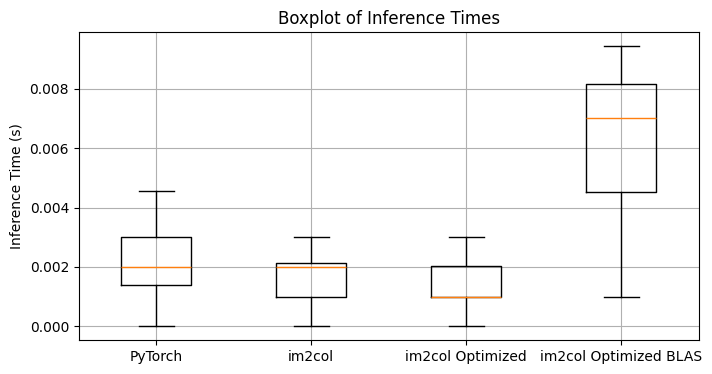

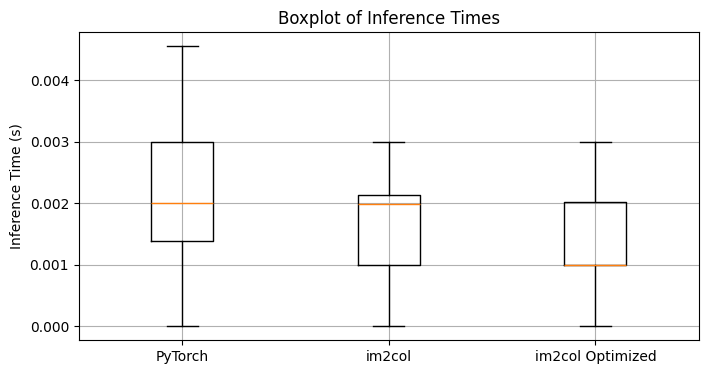


Descriptive Statistics of Inference Times:
         PyTorch  Nested Loops     im2col  im2col Optimized  \
count  20.000000     20.000000  20.000000         20.000000   
mean    0.002148      1.176077   0.001828          0.001496   
std     0.001094      0.200960   0.001020          0.000986   
min     0.000000      1.073638   0.000000          0.000000   
25%     0.001382      1.088062   0.001002          0.001000   
50%     0.002005      1.100658   0.001982          0.001003   
75%     0.002996      1.155623   0.002138          0.002015   
max     0.004551      1.951813   0.004513          0.004515   

       im2col Optimized BLAS  
count              20.000000  
mean                0.006983  
std                 0.003655  
min                 0.001000  
25%                 0.004510  
50%                 0.007010  
75%                 0.008156  
max                 0.019037  


In [96]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyoff
import pandas as pd
import sys
import gc

np_k1 = numpy_weights['k1'].astype(np.float32)
np_b_conv1 = numpy_weights['b_conv1'].astype(np.float32)
np_k2 = numpy_weights['k2'].astype(np.float32)
np_b_conv2 = numpy_weights['b_conv2'].astype(np.float32)
np_k3 = numpy_weights['k3'].astype(np.float32)
np_b_conv3 = numpy_weights['b_conv3'].astype(np.float32)
np_w1 = numpy_weights['w1'].astype(np.float32)
np_b1 = numpy_weights['b1'].astype(np.float32)
np_w2 = numpy_weights['w2'].astype(np.float32)
np_b2 = numpy_weights['b2'].astype(np.float32)

dict_times={}
dict_times["pytorch_model"]=[]
dict_times["nested_loops"]=[]
dict_times["im2col"]=[]
dict_times["im2col_optimized"]=[]
dict_times["im2col_optimized_blas"]=[]

dict_pred={}
dict_pred["pytorch_model"]=[]
dict_pred["nested_loops"]=[]
dict_pred["im2col"]=[]
dict_pred["im2col_optimized"]=[]
dict_pred["im2col_optimized_blas"]=[]

# torch garbage collection
torch.cuda.empty_cache()
gc.collect()

correct = 0
count = 0

skip = True
loop = tqdm(range(0, test_labels.shape[0], 500), desc=" Inferring...")
for i in loop:
    c0 = test_images[i].reshape(1,1,28,28)
    torch_c0 = torch.from_numpy(c0).float()

    ############### CNN PyTorch Implementation ##################
    start_time = time.time()
    outputs = model(torch_c0)
    end_time = time.time()
    _, pred_pytorch = torch.max(outputs.data, 1)
    dict_times["pytorch_model"].append(end_time-start_time)
    dict_pred["pytorch_model"].append(np.array(pred_pytorch))

    ############### CNN nested loops Implementation #####################
    start_time = time.time()
    c1s,mask1s = nested_loop_convolution(c0,np_k1,np_b_conv1,padding=0,stride=2)
    c2s,mask2s = nested_loop_convolution(c1s,np_k2,np_b_conv2,padding=1,stride=2)
    c3s,mask3s = nested_loop_convolution(c2s,np_k3,np_b_conv3,padding=0,stride=2)
    imlps = c3s.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlps,np_w1,np_b1,np_w2,np_b2)
    pred_nested_loops = np.argmax(res,1)
    end_time = time.time()
    dict_times["nested_loops"].append(end_time-start_time)
    dict_pred["nested_loops"].append(np.array(pred_nested_loops))

    ############### CNN im2col Implementation #####################
    start_time = time.time()
    c1f,mask1f = im2col_convolution(c0,np_k1,np_b_conv1,padding=0,stride=2)
    c2f,mask2f = im2col_convolution(c1f,np_k2,np_b_conv2,padding=1,stride=2)
    c3f,mask3f = im2col_convolution(c2f,np_k3,np_b_conv3,padding=0,stride=2)
    imlpf = c3f.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlpf,np_w1,np_b1,np_w2,np_b2)
    pred_im2col = np.argmax(res,1)
    end_time = time.time()
    dict_times["im2col"].append(end_time-start_time)
    dict_pred["im2col"].append(np.array(pred_im2col))

    ############## CNN optimized im2col Implementation ###########
    start_time = time.time()
    c1c,mask1c = im2col_optimized(c0,np_k1,np_b_conv1,padding=0,stride=2)
    c2c,mask2c = im2col_optimized(c1c,np_k2,np_b_conv2,padding=1,stride=2)
    c3c,mask3c = im2col_optimized(c2c,np_k3,np_b_conv3,padding=0,stride=2)
    imlpc = c3c.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlpc,np_w1,np_b1,np_w2,np_b2)
    pred_im2col_optim = np.argmax(res,1)
    end_time = time.time()
    dict_times["im2col_optimized"].append(end_time-start_time)
    dict_pred["im2col_optimized"].append(np.array(pred_im2col_optim))

    ############## CNN BLAS im2col Implementation ###########
    start_time = time.time()
    c1c,mask1c = im2col_optimized_blas(c0,np_k1,np_b_conv1,padding=0,stride=2)
    c2c,mask2c = im2col_optimized_blas(c1c,np_k2,np_b_conv2,padding=1,stride=2)
    c3c,mask3c = im2col_optimized_blas(c2c,np_k3,np_b_conv3,padding=0,stride=2)
    imlpc = c3c.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlpc,np_w1,np_b1,np_w2,np_b2)
    pred_im2col_blas = np.argmax(res,1)
    end_time = time.time()
    dict_times["im2col_optimized_blas"].append(end_time-start_time)
    dict_pred["im2col_optimized_blas"].append(np.array(pred_im2col_blas))

    #####################################################################################
    #### Check that outputs of Slow Approach and Fast Approach have the same results ###
    if pred_pytorch == pred_nested_loops and pred_pytorch == pred_im2col and pred_pytorch == pred_im2col_optim and pred_pytorch == pred_im2col_blas:
        correct += 1

    count += 1

    #####################################################################################
    ### Keep track of the times #########################################################
    pytorch_avg_time = round(sum(dict_times['pytorch_model'])/(i+1),10) * 1000
    nested_loops_avg_time = round(sum(dict_times['nested_loops'])/(i+1),10) * 1000
    im2col_avg_time = round(sum(dict_times['im2col'])/(i+1),10) * 1000
    im2col_optim_avg_time = round(sum(dict_times['im2col_optimized'])/(i+1),10) * 1000
    im2col_blas_avg_time = round(sum(dict_times['im2col_optimized_blas'])/(i+1),10) * 1000

    accuracy_percentage = (correct / count) * 100 if count > 0 else 0.0

    loop.set_postfix(
        pytorch=f"{pytorch_avg_time:>8.4f} s",
        im2col=f"{im2col_avg_time:>8.4f} s",
        im2col_opt=f"{im2col_optim_avg_time:>8.4f} s",
        nested_loops=f"{nested_loops_avg_time:>8.4f} s",
        im2col_blas=f"{im2col_blas_avg_time:>8.4f} s",
        accuracy=f"{accuracy_percentage:>7.2f} %"
    )

sys.stdout.write("\n")
sys.stdout.flush()

pytorch_avg_time = np.mean(dict_times['pytorch_model'])
nested_loops_avg_time = np.mean(dict_times['nested_loops'])
im2col_avg_time = np.mean(dict_times['im2col'])
im2col_optim_avg_time = np.mean(dict_times['im2col_optimized'])
im2col_blas_avg_time = np.mean(dict_times['im2col_optimized_blas'])

print(f"Average inference time in seconds:\nPyTorch:\t{pytorch_avg_time} s,\nim2col:\t\t{im2col_avg_time} s, \nim2col_optim:\t{im2col_optim_avg_time} s, \nnested_loops:\t{nested_loops_avg_time} s,\nim2col_blas:\t{im2col_blas_avg_time} s")

# Plot times altogether

# Create interactive traces for each method
for method, times in dict_times.items():
    trace = go.Scatter(
        x=list(range(len(times))),
        y=times,
        mode='lines+markers',
        name=method,
        line=dict(width=2),
        marker=dict(size=4)
    )
    if method == 'pytorch_model':
        trace_pytorch = trace
    elif method == 'nested_loops':
        trace_nested_loops = trace
    elif method == 'im2col':
        trace_im2col = trace
    elif method == 'im2col_optimized':
        trace_im2col_optimized = trace
    elif method == 'im2col_optimized_blas':
        trace_blas = trace

data = [trace_pytorch, trace_nested_loops, trace_im2col, trace_im2col_optimized, trace_blas]

layout = go.Layout(
    title='Inference Time Comparison (Interactive)',
    xaxis=dict(title='Batch Index'),
    yaxis=dict(title='Inference Time (s)'),
    width=1400,
    height=500,
    legend=dict(x=0, y=1),
    hovermode='x unified'
)

fig = go.Figure(data=data, layout=layout)
pyoff.iplot(fig)

# Also plot some boxplots for better visualization
plt.figure(figsize=(8, 4))
plt.boxplot([dict_times['pytorch_model'], dict_times['im2col'], dict_times['im2col_optimized'], dict_times['im2col_optimized_blas']],
            tick_labels=['PyTorch', 'im2col', 'im2col Optimized', 'im2col Optimized BLAS'],
            showfliers=False)
plt.ylabel('Inference Time (s)')
plt.title('Boxplot of Inference Times')
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.boxplot([dict_times['pytorch_model'], dict_times['im2col'], dict_times['im2col_optimized']],
            tick_labels=['PyTorch', 'im2col', 'im2col Optimized'],
            showfliers=False)
plt.ylabel('Inference Time (s)')
plt.title('Boxplot of Inference Times')
plt.grid()
plt.show()

df_times = pd.DataFrame({
    'PyTorch': dict_times['pytorch_model'],
    'Nested Loops': dict_times['nested_loops'],
    'im2col': dict_times['im2col'],
    'im2col Optimized': dict_times['im2col_optimized'],
    'im2col Optimized BLAS': dict_times['im2col_optimized_blas']
})
print("\nDescriptive Statistics of Inference Times:")
print(df_times.describe())

## Training

In this panel the approach is tested to see if it learns or not. the test uses first just one image, then the first 100 for each eopch, in order to see if the loss descends during the training

### NumPy Model Training: Weights Initialization

For training our NumPy CNNs from scratch, weights and biases are initialized randomly.
The shapes are taken from `numpy_weights` (derived from the PyTorch model) to maintain architectural consistency. `np.random.rand()` provides initial values (uniform in [0,1)). While more advanced initializers exist, this suffices for observing basic learning.

In [20]:
random_seed = 42
np.random.seed(random_seed)

def initialize_weights():
    weights = {}
    weights['k1'] = np.random.rand(*numpy_weights['k1'].shape)
    weights['bc1'] = np.random.rand(*numpy_weights['b_conv1'].shape)
    weights['k2'] = np.random.rand(*numpy_weights['k2'].shape)
    weights['bc2'] = np.random.rand(*numpy_weights['b_conv2'].shape)
    weights['k3'] = np.random.rand(*numpy_weights['k3'].shape)
    weights['bc3'] = np.random.rand(*numpy_weights['b_conv3'].shape)
    weights['w1'] = np.random.rand(*numpy_weights['w1'].shape)
    weights['b1'] = np.random.rand(*numpy_weights['b1'].shape)
    weights['w2'] = np.random.rand(*numpy_weights['w2'].shape)
    weights['b2'] = np.random.rand(*numpy_weights['b2'].shape)
    return weights

weights = initialize_weights()

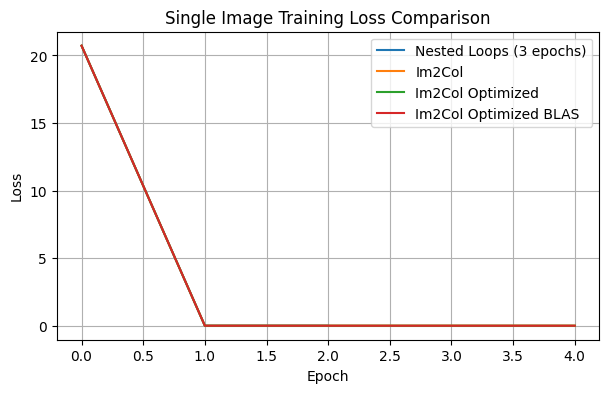

Nested Loops (3 epochs): -0.000000
Predict: 5
Probabilities: [[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.23196934
  0.08533674 0.08533674 0.08533674 0.08533674]]

Im2Col: -0.000000
Predict: 5
Probabilities: [[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.23196934
  0.08533674 0.08533674 0.08533674 0.08533674]]

Im2Col Optimized: -0.000000
Predict: 5
Probabilities: [[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.23196934
  0.08533674 0.08533674 0.08533674 0.08533674]]

Im2Col Optimized BLAS: -0.000000
Predict: 5
Probabilities: [[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.23196934
  0.08533674 0.08533674 0.08533674 0.08533674]]



In [29]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm # Ensure tqdm is imported

# --- Helper: NumPy Single Image Training ---
def train_single_image_numpy(
    initial_weights_dict, 
    train_image_np, # (1, 1, 28, 28), normalized
    train_label_np, # one-hot (1, 10)
    forward_conv_fn, 
    backward_conv_fn, 
    num_epochs, 
    lr,
    bs=1 # Batch size, fixed to 1 for single image training
    ):

    # Initialize weights (make copies to not modify the initial_weights_dict)
    k1 = initial_weights_dict['k1'].copy().astype(np.float32)
    bc1 = initial_weights_dict['bc1'].copy().astype(np.float32)
    k2 = initial_weights_dict['k2'].copy().astype(np.float32)
    bc2 = initial_weights_dict['bc2'].copy().astype(np.float32)
    k3 = initial_weights_dict['k3'].copy().astype(np.float32)
    bc3 = initial_weights_dict['bc3'].copy().astype(np.float32)
    w1 = initial_weights_dict['w1'].copy().astype(np.float32)
    b1 = initial_weights_dict['b1'].copy().astype(np.float32)
    w2 = initial_weights_dict['w2'].copy().astype(np.float32)
    b2 = initial_weights_dict['b2'].copy().astype(np.float32)
    
    losses = []

    for epoch in range(num_epochs):
        # Forward pass
        c1_out, mask1 = forward_conv_fn(train_image_np, k1, bc1, padding=0, stride=2, applyReLU=True)
        c2_out, mask2 = forward_conv_fn(c1_out, k2, bc2, padding=1, stride=2, applyReLU=True)
        c3_out, mask3 = forward_conv_fn(c2_out, k3, bc3, padding=0, stride=2, applyReLU=True)
        
        mlp_input = c3_out.reshape(bs, -1)
        fl, fa, sl, sa = ReLU_SoftMax_FullyConnected(mlp_input, w1, b1, w2, b2)
        
        # Loss
        loss = crossEntropy(sa, train_label_np) # Ensure train_label_np is (1, 10)
        losses.append(loss)
        
        # Backward pass
        dL_i_mlp, dL_dw1, dL_db1, dL_dw2, dL_db2 = ReLU_SoftMax_FC_Backward(bs, sa, train_label_np, w1, w2, fa, fl, mlp_input)
        dL_i_mlp_reshaped = dL_i_mlp.reshape(c3_out.shape)
        
        gi3, gk3, gb3 = backward_conv_fn(c2_out, dL_i_mlp_reshaped, k3, mask3, padding=0, stride=2)
        gi2, gk2, gb2 = backward_conv_fn(c1_out, gi3, k2, mask2, padding=1, stride=2)
        gi1, gk1, gb1 = backward_conv_fn(train_image_np, gi2, k1, mask1, padding=0, stride=2)
        
        # Weight update
        w1  -= lr * dL_dw1
        b1  -= lr * dL_db1.reshape(b1.shape) # Ensure b1 update matches b1 shape
        w2  -= lr * dL_dw2
        b2  -= lr * dL_db2.reshape(b2.shape) # Ensure b2 update matches b2 shape
        k1  -= lr * gk1
        bc1 -= lr * gb1.reshape(bc1.shape)
        k2  -= lr * gk2
        bc2 -= lr * gb2.reshape(bc2.shape)
        k3  -= lr * gk3
        bc3 -= lr * gb3.reshape(bc3.shape)
        
    return losses, {"k1":k1, "k2":k2, "k3":k3, "w1":w1, "w2":w2, "bc1":bc1, "bc2":bc2, "bc3":bc3, "b1":b1, "b2":b2} # Return final weights

# --- Training Setup ---
# Prepare single training image and label
# Assuming train_images and train_labels are already loaded and one-hot encoded
single_train_image_np = train_images[0].reshape(1, 1, 28, 28).astype(np.float32) / 255.0
single_train_label_np = train_labels[0].reshape(1,10).astype(np.float32) # Ensure it's (1,10)

single_train_image_torch = torch.from_numpy(single_train_image_np)
# For CrossEntropyLoss, PyTorch can take one-hot targets if they have shape (N,C)
# or class indices (N). Let's use one-hot to be consistent with NumPy loss.
single_train_label_torch = torch.from_numpy(single_train_label_np)


num_epochs_single_img = 5
lr_single_img = 0.001

all_losses = {}

# --- Train Nested Loops NumPy Model ---
# This will be very slow, consider reducing num_epochs_single_img for this one if needed for quick testing
# print("Training Nested Loops NumPy model on a single image...")
nested_loops_losses, _ = train_single_image_numpy(weights, single_train_image_np, single_train_label_np, 
                                                nested_loop_convolution, nested_loop_gradient, 
                                                3, lr_single_img) # Reduced epochs for speed
all_losses['Nested Loops (3 epochs)'] = nested_loops_losses
# print("Done.\n")

# --- Train Im2Col (Unoptimized) NumPy Model ---
# print("Training Im2Col NumPy model on a single image...")
im2col_losses, _ = train_single_image_numpy(weights, single_train_image_np, single_train_label_np, 
                                       im2col_convolution, im2col_gradient, 
                                       num_epochs_single_img, lr_single_img)
all_losses['Im2Col'] = im2col_losses
# print("Done.\n")

# --- Train Im2Col Optimized NumPy Model ---
# print("Training Im2Col Optimized NumPy model on a single image...")
im2col_opt_losses, _ = train_single_image_numpy(weights, single_train_image_np, single_train_label_np, 
                                           im2col_optimized, im2col_gradient_optimized, 
                                           num_epochs_single_img, lr_single_img)
all_losses['Im2Col Optimized'] = im2col_opt_losses
# print("Done.\n")

# --- Train Im2Col Optimized BLAS NumPy Model ---
# print("Training Im2Col Optimized BLAS NumPy model on a single image...")
im2col_blas_losses, _ = train_single_image_numpy(weights, single_train_image_np, single_train_label_np, 
                                            im2col_optimized_blas, im2col_gradient_optimized_blas, 
                                            num_epochs_single_img, lr_single_img)
all_losses['Im2Col Optimized BLAS'] = im2col_blas_losses
# print("Done.\n")

# --- Plotting Losses ---
plt.figure(figsize=(7, 4))
for method_name, losses_list in all_losses.items():
    plt.plot(losses_list, label=method_name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Single Image Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Compare final losses (approximate check) ---
# print("\nFinal losses after training on a single image:")
for method_name, losses_list in all_losses.items():
    if losses_list: # Check if list is not empty
        print(f"{method_name}: {losses_list[-1]:.6f}\nPredict: {np.argmax(single_train_label_np)}\nProbabilities: {softmax(single_train_label_np)}\n")

* ### Pytorch version

100%|██████████| 20/20 [00:00<00:00, 306.15it/s]

Final logits: [ 1.3480205e+05  1.2573266e+05 -1.2074309e+09  1.2417880e+05
  1.2127320e+05  1.2076914e+09  1.2308734e+05  1.2487083e+05
  1.2810571e+05  1.2339884e+05]
Final prediction: 5


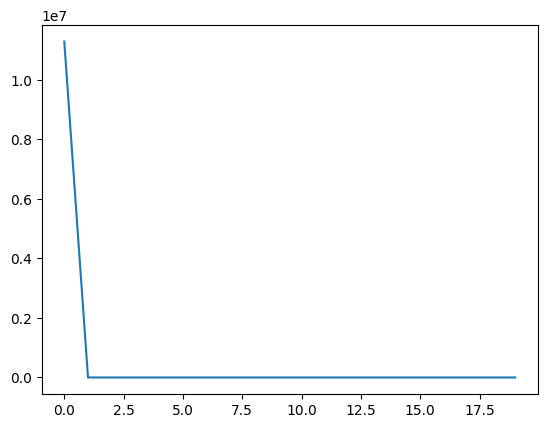

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import torch

avg_loss = []
forward_time = []
backward_time = []
numEpochs = 20
bs = 1
lr = 0.001

# Convert and reshape weights for PyTorch (Conv2d expects (out_channels, in_channels, H, W), Linear expects (out_features, in_features))
k1 = torch.from_numpy(weights['k1'].astype(np.float32)).clone()
bc1 = torch.from_numpy(weights['bc1'].astype(np.float32)).clone()
k2 = torch.from_numpy(weights['k2'].astype(np.float32)).clone()
bc2 = torch.from_numpy(weights['bc2'].astype(np.float32)).clone()
k3 = torch.from_numpy(weights['k3'].astype(np.float32)).clone()
bc3 = torch.from_numpy(weights['bc3'].astype(np.float32)).clone()
w1 = torch.from_numpy(weights['w1'].astype(np.float32)).clone()
if w1.ndim == 2:
    w1 = w1
elif w1.ndim == 1:
    w1 = w1.unsqueeze(0)
b1 = torch.from_numpy(weights['b1'].astype(np.float32)).clone().view(-1)
w2 = torch.from_numpy(weights['w2'].astype(np.float32)).clone()
if w2.ndim == 2:
    w2 = w2
elif w2.ndim == 1:
    w2 = w2.unsqueeze(0)
b2 = torch.from_numpy(weights['b2'].astype(np.float32)).clone().view(-1)

pytorch_model = SimpleCNN(num_classes=10)
pytorch_model.load_state_dict({
    'conv1.weight': k1,
    'conv1.bias': bc1,
    'conv2.weight': k2,
    'conv2.bias': bc2,
    'conv3.weight': k3,
    'conv3.bias': bc3,
    'fc1.weight': w1.T,
    'fc1.bias': b1,
    'fc2.weight': w2.T,
    'fc2.bias': b2
})

optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=0.001)

loop = tqdm(range(numEpochs))
for i in loop:
    c0 = torch.from_numpy(train_images[0].reshape(1,1,28,28).astype(np.float32) / 255.0)
    
    prediction = pytorch_model(c0)
    
    loss = nn.CrossEntropyLoss()(prediction[0], torch.tensor(train_labels[0]))
    avg_loss.append(loss.item())
    optimizer.zero_grad()

    # Weights update
    loss.backward()
    
    optimizer.step()

    if i == numEpochs - 1:
        # Get the result before the last relu
        logits = prediction[0].detach().numpy()
    

# Plot the loss
print(f"Final logits: {logits}")
print(f"Final prediction: {np.argmax(logits)}")
plt.plot(avg_loss)
plt.show()

---

### CuPy optimization

In [30]:
import cupy as cp
import time

# --- CuPy dilate function (similar to NumPy's) ---
def dilate_cupy(tensor_cp, stride):
    if stride == 1:
        return tensor_cp
    batch_size, num_channels, height, width = tensor_cp.shape
    dilated_height = height + (height - 1) * (stride - 1)
    dilated_width = width + (width - 1) * (stride - 1)
    dilated_tensor_cp = cp.zeros((batch_size, num_channels, dilated_height, dilated_width), dtype=tensor_cp.dtype)
    dilated_tensor_cp[:, :, ::stride, ::stride] = tensor_cp
    return dilated_tensor_cp

# --- CuPy im2col_optimized_forward (inspired by your im2col_optimized) ---
def im2col_cupy_forward(batch_of_images_cp, kernels_cp, biases_cp=None, padding=0, stride=1, applyReLU=True):
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels_cp.shape
    
    if padding > 0:
        batch_of_images_padded_cp = cp.pad(batch_of_images_cp, 
                                         ((0,0),(0,0),(padding,padding),(padding,padding)), 
                                         mode='constant', constant_values=0)
    else:
        batch_of_images_padded_cp = batch_of_images_cp

    batch_size, input_channels, image_height_padded, image_width_padded = batch_of_images_padded_cp.shape

    # CuPy's as_strided is equivalent to np.lib.stride_tricks.sliding_window_view's underlying mechanism
    # Output patch shape: (input_channels, kernel_height, kernel_width)
    # Strides of batch_of_images_padded_cp
    B_s, C_s, H_s, W_s = batch_of_images_padded_cp.strides
    
    output_height = (image_height_padded - kernel_height) // stride + 1
    output_width  = (image_width_padded - kernel_width) // stride + 1

    shape_col = (batch_size, output_height, output_width, input_channels, kernel_height, kernel_width)
    strides_col = (B_s, H_s * stride, W_s * stride, C_s, H_s, W_s)
    
    X_col_view = cp.lib.stride_tricks.as_strided(batch_of_images_padded_cp, shape=shape_col, strides=strides_col)
    X_col = X_col_view.reshape(batch_size * output_height * output_width, -1) # (B*H_out*W_out, C_in*KH*KW)

    W_col = kernels_cp.reshape(kernels_number, -1).T # (C_in*KH*KW, K_num)
    
    images_dot_kernels_cp = cp.matmul(X_col, W_col) # (B*H_out*W_out, K_num)
    
    output_reshaped_cp = images_dot_kernels_cp.reshape(batch_size, output_height, output_width, kernels_number)
    output_cp = output_reshaped_cp.transpose(0, 3, 1, 2) # (B, K_num, H_out, W_out)

    if biases_cp is not None and biases_cp.any() != 0: # .any() is needed for CuPy
        output_cp = output_cp + biases_cp.reshape(1, -1, 1, 1)

    mask_cp = None
    if applyReLU:
        output_activated_cp = cp.maximum(0, output_cp)
        mask_cp = (output_activated_cp > 0).astype(output_cp.dtype)
        output_cp = output_activated_cp
    else:
        mask_cp = cp.ones_like(output_cp, dtype=output_cp.dtype)
        
    return output_cp, mask_cp

# --- CuPy MLP Forward (Softmax needs CuPy implementation if not already done) ---
def softmax_cupy(x_cp):
    e_x_cp = cp.exp(x_cp - cp.max(x_cp, axis=-1, keepdims=True))
    return e_x_cp / cp.sum(e_x_cp, axis=-1, keepdims=True)

def ReLU_SoftMax_FullyConnected_cupy(input_array_cp, w1_cp, b1_cp, w2_cp, b2_cp):
    fl_cp = cp.matmul(input_array_cp, w1_cp) + b1_cp
    fa_cp = cp.maximum(0, fl_cp)
    sl_cp = cp.matmul(fa_cp, w2_cp) + b2_cp
    sa_cp = softmax_cupy(sl_cp)
    return fl_cp, fa_cp, sl_cp, sa_cp

# Note: CuPy backward pass (im2col_cupy_gradient) would be needed for training.
# For inference-only comparison, we only need the forward pass.
# If you need CuPy training, the im2col_gradient_optimized_blas structure can be adapted for CuPy.

ModuleNotFoundError: No module named 'cupy'